<center>
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Artem Kuznetsov, ODS Slack te
    
## <center> Exploring TED Talks

**Research plan**
    - Dataset and features description
    - Exploratory data analysis
    - Visual analysis of the features
    - Patterns, insights, pecularities of data
    - Data preprocessing
    - Metric selection
    - Feature engineering and description
    - Cross-validation, hyperparameter tuning
    - Validation and learning curves
    - Prediction for hold-out set
    - Model selection
    - Conclusions

### Part 1. Dataset and features description

TED is the conference organizer, which holds events were people from different areas can have a public talk of important ideas. Last years TED had significantly grown in popularity due video and audio recordings publications of talks.

The dataset was collected by Rounak Banik and stored to Kaggle https://www.kaggle.com/rounakbanik/ted-talks/. It's not sure how it was collected by web scrapping or by TED api (now closed). Data contains talks before September 21st, 2017.

Data set constists of two files:

ted_main.csv - metadata about talks and speakers

- comments- The number of first level comments made on the talk (number)
- description - A blurb of what the talk is about (string)
- duration - The duration of the talk in seconds (number)
- event - The TED/TEDx event where the talk took place (string)
- film_date - The Unix timestamp of the filming (date in unix time format)
- languages - The number of languages in which the talk is available (number)
- main_speaker - The first named speaker of the talk (string)
- name - The official name of the TED Talk. Includes the title and the speaker. (string)
- num_speaker - The number of speakers in the talk (number)
- published_date - The Unix timestamp for the publication of the talk on TED.com (date in unix time format)
- ratings - A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.) (json)
- related_talks - A list of dictionaries of recommended talks to watch next (json)
- speaker_occupation - The occupation of the main speaker (string)
- tags - The themes associated with the talk (list)
- title - The title of the talk (string)
- url - The URL of the talk (string)
- views - The number of views on the talk (number)

transcripts.csv - talk transcripts

- transcript - The official English transcript of the talk. (string)
- url - The URL of the talk (string)

Target of this project is to to research how can be predicted count of views.

In [436]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import scipy.stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge

DATA_PATH = '../data/'

# Set up seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

%matplotlib inline

In [437]:
plt.rcParams['figure.figsize'] = 12., 9.

### Part 2. Exploratory data analysis

In [3]:
# Load data
df_ted_main = pd.read_csv(DATA_PATH + 'ted_main.csv.zip')
df_ted_transcripts = pd.read_csv(DATA_PATH + 'transcripts.csv.zip')

In [4]:
df_ted_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null int64
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null int64
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null object
views                 2550 non-null int64
dtypes: int64(7), object(10)
memory usage: 338.8+ KB


In [5]:
df_ted_transcripts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 2 columns):
transcript    2467 non-null object
url           2467 non-null object
dtypes: object(2)
memory usage: 38.6+ KB


The datasets contains different count of records, so probably there are fewer transcripts then talks.

#### Duplicates check

In [6]:
df_ted_main[df_ted_main.duplicated()]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views


In [7]:
df_ted_transcripts[df_ted_transcripts.duplicated()]

,transcript,url
1114,I have a question for you: Are you religious? ...,https://www.ted.com/talks/jonathan_haidt_human...
1115,The recent debate over copyright laws like SOP...,https://www.ted.com/talks/rob_reid_the_8_billi...
1116,I'm going to tell you a little bit about my TE...,https://www.ted.com/talks/brene_brown_listenin...


Ok, we've got some in df_ted_transcripts, let's remove them.

In [8]:
df_ted_transcripts = df_ted_transcripts.drop_duplicates()

#### Merge datasets

In [9]:
df_ted_main.shape, df_ted_transcripts.shape

((2550, 17), (2464, 2))

In [10]:
df_ted = pd.merge(df_ted_main, df_ted_transcripts, how='left', on='url')
df_ted.shape

(2550, 18)

In [11]:
df_ted.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'transcript'],
      dtype='object')

In [12]:
df_ted.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,If you're here today — and I'm very happy that...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"About 10 years ago, I took on the task to teac..."


In [13]:
DATE_COLUMNS = 'film_date', 'published_date'
for column in DATE_COLUMNS:
    df_ted[column] = pd.to_datetime(df_ted[column], unit='s')

In [14]:
df_ted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2550 entries, 0 to 2549
Data columns (total 18 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null datetime64[ns]
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null datetime64[ns]
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null object
views                 2550 non-null int64
transcript            2464 non-null object
dtypes: datetime64[ns](2), int64(5), object(11)
memory usage: 378.5+ KB


#### Missing values

Looks like we have transcript for almost all talks but also have missing values. Also some values of speaker_ocupation is missing.

#### Recheck NA's

In [15]:
for column in df_ted.columns:
    na_count = df_ted[column].isna().sum()
    if na_count > 0:
        print('%s : %s' % (column, na_count))

speaker_occupation : 6
transcript : 86


#### Common numerics stats

In [16]:
df_ted.describe()

,comments,duration,languages,num_speaker,views
count,2550.000000,2550.000000,2550.000000,2550.000000,2.550000e+03
mean,191.562353,826.510196,27.326275,1.028235,1.698297e+06
std,282.315223,374.009138,9.563452,0.207705,2.498479e+06
min,2.000000,135.000000,0.000000,1.000000,5.044300e+04
25%,63.000000,577.000000,23.000000,1.000000,7.557928e+05
50%,118.000000,848.000000,28.000000,1.000000,1.124524e+06
75%,221.750000,1046.750000,33.000000,1.000000,1.700760e+06
max,6404.000000,5256.000000,72.000000,5.000000,4.722711e+07


In [17]:
df_ted.median()

comments           118.0
duration           848.0
languages           28.0
num_speaker          1.0
views          1124523.5
dtype: float64

### description

In [19]:
df_ted['description'].nunique(), len(df_ted['description'])

(2550, 2550)

In [20]:
df_ted['description'].str.len().describe()

count    2550.000000
mean      313.656078
std       106.381571
min        52.000000
25%       236.000000
50%       296.000000
75%       379.000000
max       769.000000
Name: description, dtype: float64

In [21]:
df_ted['duration'].values[:100]

array([1164,  977, 1286, 1116, 1190, 1305,  992, 1198, 1485, 1262, 1414,
       1538, 1550,  527, 1057, 1481, 1445,  906, 1170, 1201, 1114, 1136,
       1006, 1407, 1225, 1140, 1316, 1275, 1050, 1276, 1177, 1129, 1365,
        952,  773, 1080, 1125, 1177, 1083, 1672, 2065, 1609, 1280,  805,
       1376, 1200,  848,  210,  247,  198,  843, 1001, 1321, 1115, 1046,
       1151,  603, 1141,  825, 1385,  869, 1038, 1155, 1447, 1355, 1316,
       1645, 1021, 1211,  873, 1207, 1340,  930, 1054, 1240, 1204,  276,
        850,  891, 1012, 1399, 1011,  893, 1045,  977,  985,  163,  459,
       1308, 1929, 1205, 1031,  251,  378,  312, 1172, 1750, 1195,  201,
        858])

Each talk has an unique description.

### event

In [22]:
df_ted['event'].value_counts()

TED2014                         84
TED2009                         83
TED2016                         77
TED2013                         77
TED2015                         75
TED2011                         70
TEDGlobal 2012                  70
TED2010                         68
TEDGlobal 2011                  68
TED2007                         68
TED2017                         67
TEDGlobal 2013                  66
TED2012                         65
TEDGlobal 2009                  65
TED2008                         57
TEDGlobal 2010                  55
TEDGlobal 2014                  51
TED2006                         45
TED2005                         37
TEDIndia 2009                   35
TEDWomen 2010                   34
TED2003                         34
TEDSummit                       34
TED2004                         31
TED2002                         28
TEDWomen 2015                   28
TEDGlobal 2007                  27
TEDGlobal 2005                  26
TEDWomen 2016       

We had different type of events here whith the most popular TED2014 event. We can see TED and TEDx events, and some events differen from it. Let's investigate a little more.

In [23]:
sorted(df_ted['event'].unique())

['AORN Congress',
 'Arbejdsglaede Live',
 'BBC TV',
 'Bowery Poetry Club',
 'Business Innovation Factory',
 'Carnegie Mellon University',
 'Chautauqua Institution',
 'DICE Summit 2010',
 'DLD 2007',
 'EG 2007',
 'EG 2008',
 'Elizabeth G. Anderson School',
 "Eric Whitacre's Virtual Choir",
 'Fort Worth City Council',
 'Full Spectrum Auditions',
 'Gel Conference',
 'Global Witness HQ',
 'Handheld Learning',
 'Harvard University',
 'INK Conference',
 'Justice with Michael Sandel',
 'LIFT 2007',
 'Michael Howard Studios',
 'Mission Blue II',
 'Mission Blue Voyage',
 'New York State Senate',
 'NextGen:Charity',
 'Princeton University',
 'RSA Animate',
 'Royal Institution',
 'Serious Play 2008',
 'Skoll World Forum 2007',
 'SoulPancake',
 'Stanford University',
 'TED Dialogues',
 'TED Fellows 2015',
 'TED Fellows Retreat 2013',
 'TED Fellows Retreat 2015',
 'TED Prize Wish',
 'TED Residency',
 'TED Senior Fellows at TEDGlobal 2010',
 'TED Studio',
 'TED Talks Education',
 'TED Talks Live',
 

In [24]:
sorted(df_ted[df_ted['event'].str.startswith('TEDx')]['event'].unique())

['TEDxABQ',
 'TEDxAmazonia',
 'TEDxAmericanRiviera',
 'TEDxAmoskeagMillyard',
 'TEDxAmsterdam',
 'TEDxArendal',
 'TEDxAsheville',
 'TEDxAthens',
 'TEDxAtlanta',
 'TEDxAustin',
 'TEDxBG',
 'TEDxBeaconStreet',
 'TEDxBeirut',
 'TEDxBend',
 'TEDxBerkeley',
 'TEDxBerlin',
 'TEDxBinghamtonUniversity',
 'TEDxBloomington',
 'TEDxBoston',
 'TEDxBoston 2009',
 'TEDxBoston 2010',
 'TEDxBoston 2011',
 'TEDxBoston 2012',
 'TEDxBoulder',
 'TEDxBoulder 2011',
 'TEDxBratislava',
 'TEDxBrighton',
 'TEDxBrussels',
 'TEDxCERN',
 'TEDxCHUV',
 'TEDxCMU',
 'TEDxCaFoscariU',
 'TEDxCaltech',
 'TEDxCambridge',
 'TEDxCanberra',
 'TEDxCannes',
 'TEDxChange',
 'TEDxChapmanU',
 'TEDxClaremontColleges',
 'TEDxColbyCollege',
 'TEDxColoradoSprings',
 'TEDxColumbus',
 'TEDxColumbusWomen',
 'TEDxConcorde',
 'TEDxConcordiaUPortland',
 'TEDxCreativeCoast',
 'TEDxCrenshaw',
 'TEDxDU 2010',
 'TEDxDU 2011',
 'TEDxDanubia',
 'TEDxDeExtinction',
 'TEDxDelft',
 'TEDxDesMoines',
 'TEDxDirigo',
 'TEDxDubai',
 'TEDxDublin',
 'TED

In [25]:
sorted(df_ted[df_ted['event'].str.startswith('TEDx') == False]['event'].unique())

['AORN Congress',
 'Arbejdsglaede Live',
 'BBC TV',
 'Bowery Poetry Club',
 'Business Innovation Factory',
 'Carnegie Mellon University',
 'Chautauqua Institution',
 'DICE Summit 2010',
 'DLD 2007',
 'EG 2007',
 'EG 2008',
 'Elizabeth G. Anderson School',
 "Eric Whitacre's Virtual Choir",
 'Fort Worth City Council',
 'Full Spectrum Auditions',
 'Gel Conference',
 'Global Witness HQ',
 'Handheld Learning',
 'Harvard University',
 'INK Conference',
 'Justice with Michael Sandel',
 'LIFT 2007',
 'Michael Howard Studios',
 'Mission Blue II',
 'Mission Blue Voyage',
 'New York State Senate',
 'NextGen:Charity',
 'Princeton University',
 'RSA Animate',
 'Royal Institution',
 'Serious Play 2008',
 'Skoll World Forum 2007',
 'SoulPancake',
 'Stanford University',
 'TED Dialogues',
 'TED Fellows 2015',
 'TED Fellows Retreat 2013',
 'TED Fellows Retreat 2015',
 'TED Prize Wish',
 'TED Residency',
 'TED Senior Fellows at TEDGlobal 2010',
 'TED Studio',
 'TED Talks Education',
 'TED Talks Live',
 

We can add some feature to distinct different types of events.

In [26]:
def get_event_type(event):
    '''
    Returns type of event
    '''
    if not 'TED' in event:
        return 'NOT_TED'
    elif event.startswith('TEDx'):
        return 'TEDx'
    elif event.startswith('TED@'):
        return 'TED@'
    elif re.fullmatch('TED\d{4}', event) is not None:
        return 'TED_YEAR'
    else:
        return event.split()[0]

In [27]:
df_ted['event'].apply(get_event_type).value_counts()

TED_YEAR            978
TEDx                471
TEDGlobal           431
NOT_TED             111
TEDWomen             96
TED@                 87
TEDSalon             79
TEDMED               68
TED                  58
TEDIndia             35
TEDSummit            34
TEDYouth             19
TEDNYC               19
TEDGlobal>London     13
TEDCity2.0           11
TEDGlobal>Geneva     11
TED-Ed               10
TEDGlobalLondon       8
TEDActive             6
TEDLagos              2
TEDPrize@UN           2
TEDNairobi            1
Name: event, dtype: int64

Wikipedia has some additional info on different conference types https://en.wikipedia.org/wiki/TED_(conference)

In [28]:
df_ted.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'transcript'],
      dtype='object')

#### film_date

In [29]:
df_ted['film_date'].describe()

count                    2550
unique                    735
top       2017-04-24 00:00:00
freq                       64
first     1972-05-14 00:00:00
last      2017-08-27 00:00:00
Name: film_date, dtype: object

Some talks have filming date year as early as 1972. Let's try to find some more.

In [30]:
df_ted[df_ted['film_date'] < '2000-01-01']

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
200,64,"With surprising accuracy, Nicholas Negroponte ...",1523,TED1984,1984-02-02 00:00:00,18,Nicholas Negroponte,"Nicholas Negroponte: 5 predictions, from 1984",1,2008-03-11 01:26:00,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 7...","[{'id': 288, 'hero': 'https://pe.tedcdn.com/im...",Tech visionary,"['demo', 'design', 'entertainment', 'future', ...","5 predictions, from 1984",https://www.ted.com/talks/nicholas_negroponte_...,974087,In this rather long sort of marathon presentat...
202,9,"Before he was a legend, architect Frank Gehry ...",2678,TED1990,1990-03-03 00:00:00,19,Frank Gehry,Frank Gehry: My days as a young rebel,1,2008-03-13 01:38:00,"[{'id': 11, 'name': 'Longwinded', 'count': 76}...","[{'id': 13, 'hero': 'https://pe.tedcdn.com/ima...",Architect,"['architecture', 'collaboration', 'design', 'g...",My days as a young rebel,https://www.ted.com/talks/frank_gehry_as_a_you...,620806,I'm going to go right into the slides. And all...
260,791,"Speaking at TED in 1998, Rev. Billy Graham mar...",1580,TED1998,1998-02-02 00:00:00,27,Billy Graham,Billy Graham: On technology and faith,1,2008-07-16 01:00:00,"[{'id': 3, 'name': 'Courageous', 'count': 470}...","[{'id': 71, 'hero': 'https://pe.tedcdn.com/ima...",Preacher,"['Christianity', 'God', 'death', 'faith', 'rel...",On technology and faith,https://www.ted.com/talks/billy_graham_on_tech...,1532675,"As a clergyman, you can imagine how out of pla..."
290,66,With vibrant video clips captured by submarine...,800,TED1998,1998-02-28 00:00:00,25,David Gallo,David Gallo: Life in the deep oceans,1,2008-09-11 01:00:00,"[{'id': 10, 'name': 'Inspiring', 'count': 155}...","[{'id': 40, 'hero': 'https://pe.tedcdn.com/ima...",Oceanographer,"['animals', 'geology', 'life', 'oceans', 'scie...",Life in the deep oceans,https://www.ted.com/talks/david_gallo_on_life_...,996736,(Applause) David Gallo: This is Bill Lange. I'...
316,29,"In 1998, aircraft designer Paul MacCready look...",1368,TED1998,1998-02-02 00:00:00,19,Paul MacCready,Paul MacCready: Nature vs. humans,1,2008-10-22 01:00:00,"[{'id': 9, 'name': 'Ingenious', 'count': 47}, ...","[{'id': 74, 'hero': 'https://pe.tedcdn.com/ima...",Engineer,"['demo', 'design', 'drones', 'flight', 'green'...",Nature vs. humans,https://www.ted.com/talks/paul_maccready_on_na...,197139,You hear that this is the era of environment —...
376,67,"In this TED archive video from 1998, paralympi...",1345,TED1998,1998-02-02 00:00:00,30,Aimee Mullins,Aimee Mullins: Changing my legs - and my mindset,1,2009-01-28 01:00:00,"[{'id': 3, 'name': 'Courageous', 'count': 249}...","[{'id': 82, 'hero': 'https://pe.tedcdn.com/ima...",Athlete and actor,"['beauty', 'body language', 'design', 'prosthe...",Changing my legs - and my mindset,https://www.ted.com/talks/aimee_mullins_on_run...,1013266,"Sheryl Shade: Hi, Aimee. Aimee Mullins: Hi.SS:..."
382,21,From the TED archives: The legendary graphic d...,914,TED1998,1998-02-02 00:00:00,20,Milton Glaser,Milton Glaser: Using design to make ideas new,1,2009-02-11 01:00:00,"[{'id': 22, 'name': 'Fascinating', 'count': 58...","[{'id': 215, 'hero': 'https://pe.tedcdn.com/im...",Graphic designer,"['art', 'communication', 'creativity', 'cultur...",Using design to make ideas new,https://www.ted.com/talks/milton_glaser_on_usi...,382985,'Theme and variations' is one of those forms t...
395,91,"At TED in 1998, Brenda Laurel asks: Why are al...",788,TED1998,1998-02-02 00:00:00,30,Brenda Laurel,Brenda Laurel: Why not make video games for gi...,1,2009-03-02 01:00:00,"[{'id': 25, 'name': 'OK', 'count': 90}, {'id':...","[{'id': 361, 'hero': 'https://pe.tedcdn.com/im...",Designer and theorist,"['children', 'culture', 'design', 'entertainme...",Why not make video games for girls?,https://www.ted.com/talks/brenda_laurel_on_mak...,382517,"Back in 1992, I started working for a company ..

Can be seen that there are three talks, that are not from TED and filmed before 1992.

#### languages

In [31]:
df_ted['languages'].describe(), df_ted['languages'].median()

(count    2550.000000
 mean       27.326275
 std         9.563452
 min         0.000000
 25%        23.000000
 50%        28.000000
 75%        33.000000
 max        72.000000
 Name: languages, dtype: float64, 28.0)

Interesting, some of the talks has language count equal to zero. Let's investigate a little bit.

In [32]:
df_ted[df_ted['languages'] == 0]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
58,222,"Two Pilobolus dancers perform ""Symbiosis."" Doe...",825,TED2005,2005-02-25 00:00:00,0,Pilobolus,"Pilobolus: A dance of ""Symbiosis""",1,2007-02-09 00:11:00,"[{'id': 1, 'name': 'Beautiful', 'count': 1810}...","[{'id': 40, 'hero': 'https://pe.tedcdn.com/ima...",Dance company,"['dance', 'entertainment', 'nature', 'performa...","A dance of ""Symbiosis""",https://www.ted.com/talks/pilobolus_perform_sy...,3051507,NaN
115,27,The avant-garde string quartet Ethel performs ...,214,TED2006,2006-02-02 00:00:00,0,Ethel,"Ethel: A string quartet plays ""Blue Room""",1,2007-06-18 16:29:00,"[{'id': 1, 'name': 'Beautiful', 'count': 216},...","[{'id': 103, 'hero': 'https://pe.tedcdn.com/im...",String quartet,"['cello', 'collaboration', 'culture', 'enterta...","A string quartet plays ""Blue Room""",https://www.ted.com/talks/ethel_performs_blue_...,384641,NaN
135,36,After Vusi Mahlasela's 3-song set at TEDGlobal...,299,TEDGlobal 2007,2007-06-08 00:00:00,0,Vusi Mahlasela,"Vusi Mahlasela: ""Woza""",1,2007-08-21 11:24:00,"[{'id': 8, 'name': 'Informative', 'count': 4},...","[{'id': 158, 'hero': 'https://pe.tedcdn.com/im...","Musician, activist","['Africa', 'entertainment', 'guitar', 'live mu...","""Woza""",https://www.ted.com/talks/vusi_mahlasela_s_enc...,416603,NaN
209,67,"Rokia Traore sings the moving ""M'Bifo,"" accomp...",419,TEDGlobal 2007,2007-06-06 00:00:00,0,Rokia Traore,"Rokia Traore: ""M'Bifo""",1,2008-03-27 01:18:00,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 5...","[{'id': 265, 'hero': 'https://pe.tedcdn.com/im...",Singer-songwriter,"['Africa', 'entertainment', 'guitar', 'live mu...","""M'Bifo""",https://www.ted.com/talks/rokia_traore_sings_m...,294936,NaN
237,43,"Singer-songwriter Rokia Traore performs ""Kouna...",386,TEDGlobal 2007,2007-06-06 00:00:00,0,Rokia Traore,"Rokia Traore: ""Kounandi""",1,2008-06-05 01:00:00,"[{'id': 22, 'name': 'Fascinating', 'count': 84...","[{'id': 186, 'hero': 'https://pe.tedcdn.com/im...",Singer-songwriter,"['Africa', 'guitar', 'live music', 'music', 's...","""Kounandi""",https://www.ted.com/talks/rokia_traore_sings_k...,82488,NaN
249,50,Composer Sxip Shirey makes music from the simp...,186,TED2008,2008-02-12 00:00:00,0,Sxip Shirey + Rachelle Garniez,Sxip Shirey + Rachelle Garniez: A performance ...,2,2008-06-30 01:00:00,"[{'id': 9, 'name': 'Ingenious', 'count': 44}, ...","[{'id': 115, 'hero': 'https://pe.tedcdn.com/im...",Musician,"['entertainment', 'live music', 'music']","A performance with breath, music, passion",https://www.ted.com/talks/sxip_shirey_at_the_b...,217663,NaN
399,194,"Eric Lewis, an astonishingly talented crossove...",636,TED2009,2009-02-06 00:00:00,0,Eric Lewis,Eric Lewis: Piano jazz that rocks,1,2009-03-06 01:00:00,"[{'id': 21, 'name': 'Unconvincing', 'count': 8...","[{'id': 46, 'hero': 'https://pe.tedcdn.com/ima...",Pianist,"['entertainment', 'innovation', 'invention', '...",Piano jazz that rocks,https://www.ted.com/talks/eric_lewis_strikes_c...,697257,NaN
446,138,Eric Lewis explores the piano's expressive pow...,294,TED2009,2009-02-05 00:00:00,0,Eric Lewis,Eric Lewis: Chaos and harmony on piano,1,2009-05-12 01:00:00,"[{'id': 26, 'name': 'Obnoxious', 'count': 84},...","[{'id': 478, 'hero': 'https://pe.tedcdn.com/im...",Pianist,"['art', 'entertainment', 'live music', 'music'...",Chaos and harmony on piano,https://www.ted.com/talks/eric_lewis_plays_cha...,391427,NaN
474,135,Organ virtuoso Qi Zhang plays her electric ren...,185,TEDxUSC,2009-03-23 00:00:00,0,Qi Zhang,Qi Zhang: An electrifying organ performance,1,2009-06-19 08:50:00,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 3...","[{'id': 46, 'hero': 'https://pe.tedcdn.com/ima...",Organist,"['TEDx', 'china', 'music', 'performance', 'pia...",An electrifying organ performance,https://www.ted.com/talks/qi_zhang_s_electrify...,803691,NaN
512,146,Vishal Vaid an

In [33]:
df_ted[df_ted['languages'] == 0]['url'].values[:10]

array(['https://www.ted.com/talks/pilobolus_perform_symbiosis\n',
       'https://www.ted.com/talks/ethel_performs_blue_room\n',
       'https://www.ted.com/talks/vusi_mahlasela_s_encore_at_tedglobal2007\n',
       'https://www.ted.com/talks/rokia_traore_sings_m_bifo\n',
       'https://www.ted.com/talks/rokia_traore_sings_kounandi\n',
       'https://www.ted.com/talks/sxip_shirey_at_the_breathing_place\n',
       'https://www.ted.com/talks/eric_lewis_strikes_chords_to_rock_the_jazz_world\n',
       'https://www.ted.com/talks/eric_lewis_plays_chaos_and_harmony\n',
       'https://www.ted.com/talks/qi_zhang_s_electrifying_organ_performance\n',
       'https://www.ted.com/talks/vishal_vaid_s_hypnotic_song\n'],
      dtype=object)

Most of those are art perfomances, but not all. Also for those records there is no transcript.

#### main_speaker

In [34]:
df_ted['main_speaker'].value_counts()

Hans Rosling                                  9
Juan Enriquez                                 7
Marco Tempest                                 6
Rives                                         6
Nicholas Negroponte                           5
Bill Gates                                    5
Jacqueline Novogratz                          5
Clay Shirky                                   5
Julian Treasure                               5
Dan Ariely                                    5
Steven Johnson                                4
Ken Robinson                                  4
Eve Ensler                                    4
Chris Anderson                                4
David Pogue                                   4
Lawrence Lessig                               4
Jonathan Haidt                                4
Dan Dennett                                   4
Barry Schwartz                                4
Robert Full                                   4
Jonathan Drori                          

In [35]:
df_ted['main_speaker'].value_counts().describe()

count    2156.000000
mean        1.182746
std         0.574799
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: main_speaker, dtype: float64

Most of people have a talk at TED events only once.

In [36]:
df_ted['main_speaker'].str.len().describe()

count    2550.000000
mean       13.552157
std         4.119468
min         2.000000
25%        11.000000
50%        13.000000
75%        15.000000
max        58.000000
Name: main_speaker, dtype: float64

In [37]:
df_ted[df_ted['main_speaker'].str.len() > 20]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
83,335,"Savage-Rumbaugh's work with bonobo apes, which...",1045,TED2004,2004-02-02,28,Susan Savage-Rumbaugh,Susan Savage-Rumbaugh: The gentle genius of bo...,1,2007-04-05 00:11:00,"[{'id': 1, 'name': 'Beautiful', 'count': 544},...","[{'id': 340, 'hero': 'https://pe.tedcdn.com/im...",Primate authority,"['animals', 'apes', 'biology', 'culture', 'evo...",The gentle genius of bonobos,https://www.ted.com/talks/susan_savage_rumbaug...,2197377,"I work with a species called ""Bonobo."" And I'm..."
101,56,Google co-founders Larry Page and Sergey Brin ...,1233,TED2004,2004-02-02,31,Sergey Brin + Larry Page,Sergey Brin + Larry Page: The genesis of Google,2,2007-05-03 17:51:00,"[{'id': 11, 'name': 'Longwinded', 'count': 143...","[{'id': 319, 'hero': 'https://pe.tedcdn.com/im...","Computer scientist, entrepreneur and philanthr...","['Google', 'TED Brain Trust', 'business', 'col...",The genesis of Google,https://www.ted.com/talks/sergey_brin_and_larr...,1451846,Sergey Brin: I want to discuss a question I kn...
103,328,"In James Howard Kunstler's view, public spaces...",1184,TED2004,2004-02-02,21,James Howard Kunstler,James Howard Kunstler: The ghastly tragedy of ...,1,2007-05-12 08:20:00,"[{'id': 7, 'name': 'Funny', 'count': 1006}, {'...","[{'id': 123, 'hero': 'https://pe.tedcdn.com/im...",Social critic,"['alternative energy', 'architecture', 'cars',...",The ghastly tragedy of the suburbs,https://www.ted.com/talks/james_howard_kunstle...,1683456,The immersive ugliness of our everyday environ...
108,260,Blaise Aguera y Arcas leads a dazzling demo of...,450,TED2007,2007-03-03,34,Blaise Agüera y Arcas,Blaise Agüera y Arcas: How PhotoSynth can conn...,1,2007-05-27 00:37:00,"[{'id': 1, 'name': 'Beautiful', 'count': 632},...","[{'id': 147, 'hero': 'https://pe.tedcdn.com/im...",Software architect,"['collaboration', 'demo', 'microsoft', 'photog...",How PhotoSynth can connect the world's images,https://www.ted.com/talks/blaise_aguera_y_arca...,4772595,"What I'm going to show you first, as quickly a..."
193,46,"Two TED favorites, Jill Sobule and Julia Sween...",374,TED2007,2007-03-03,23,Jill Sobule + Julia Sweeney,Jill Sobule + Julia Sweeney: The Jill and Juli...,2,2008-02-20 01:03:00,"[{'id': 3, 'name': 'Courageous', 'count': 34},...","[{'id': 86, 'hero': 'https://pe.tedcdn.com/ima...",Singer/songwriter,"['collaboration', 'comedy', 'entertainment', '...",The Jill and Julia Show,https://www.ted.com/talks/the_jill_and_julia_s...,487972,♫ Jill Sobule: At a conference in Monterey by ...
197,70,Educator Roy Gould and researcher Curtis Wong ...,402,TED2008,2008-02-27,26,Roy Gould + Curtis Wong,Roy Gould + Curtis Wong: A preview of the Worl...,2,2008-02-27 23:00:00,"[{'id': 8, 'name': 'Informative', 'count': 170...","[{'id': 178, 'hero': 'https://pe.tedcdn.com/im...",Researcher,"['astronomy', 'collaboration', 'demo', 'scienc...",A preview of the WorldWide Telescope,https://www.ted.com/talks/roy_gould_and_curtis...,1034064,"Roy Gould: Less than a year from now, the worl..."
216,87,Tod Machover of MIT's Media Lab is devoted to ...,1241,TED2008,2008-03-03,21,Tod Machover + Dan Ellsey,Tod Machover + Dan Ellsey: Inventing instrumen...,2,2008-04-15 03:25:00,"[{'id': 22, 'name': 'Fascinating', 'count': 16...","[{'id': 103, 'hero': 'https://pe.tedcdn.com/im...","Composer, inventor","['creativity', 'demo', 'design', 'entertainmen...",Inventing instruments that unlock new music,https://www.ted.com/talks/tod_machover_and_dan...,497153,The first idea I'd like to suggest is that we ...
249,50,Composer Sxip Shirey makes music from the simp...,186,TED2008,2008-02-12,0,Sxip Shirey + Rachelle Garniez,Sxip Shirey + Rachelle Garniez: A performance ...,2,2008-06-30 01:00:00,"[{'id': 9, 'name': 'Ingenious', 'count': 44}, ...","[{'id': 115, 'hero': 'https://pe.tedcdn.com/im...",Musician,"['entertainment', 

In case of long main_speaker field we can suspect more then one speaker.

#### name

In [38]:
df_ted['name'].nunique()

2550

Every talk has an unique name.

In [39]:
df_ted['name'].str.len().describe()

count    2550.000000
mean       50.654510
std        12.602419
min        19.000000
25%        42.000000
50%        49.000000
75%        59.000000
max       100.000000
Name: name, dtype: float64

#### num_speaker

In [40]:
df_ted['num_speaker'].describe()

count    2550.000000
mean        1.028235
std         0.207705
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: num_speaker, dtype: float64

Most of people present their talks alone.

#### published_date

In [41]:
df_ted['published_date'].describe()

count                    2550
unique                   2490
top       2007-04-05 00:11:00
freq                       20
first     2006-06-27 00:11:00
last      2017-09-22 15:00:22
Name: published_date, dtype: object

In [42]:
df_ted[df_ted['event'].str.startswith('TED')]['film_date'].min()

Timestamp('1984-02-02 00:00:00')

Fist published_date is 2006-06-27, but first filmed talk was on 1984-02-02. So it may be interesting to have a look at timespan between the filming and the publication.

In [43]:
(df_ted['published_date'] - df_ted['film_date']).describe()

count                        2550
mean     249 days 23:21:53.703529
std      616 days 14:41:39.952308
min           -348 days +04:57:00
25%       49 days 15:00:10.750000
50%             100 days 05:21:30
75%             190 days 12:45:15
max           13879 days 14:37:00
dtype: object

In [44]:
(df_ted['published_date'] - df_ted['film_date']).median()

Timedelta('100 days 05:21:30')

In [45]:
df_ted[(df_ted['published_date'] - df_ted['film_date']).dt.total_seconds() < 0]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
323,76,While we all agree that compassion is a great ...,946,TEDSalon 2009 Compassion,2009-10-01,30,Jackie Tabick,Jackie Tabick: The balancing act of compassion,1,2008-10-31 04:17:00,"[{'id': 25, 'name': 'OK', 'count': 14}, {'id':...","[{'id': 676, 'hero': 'https://pe.tedcdn.com/im...",Spiritual leader,"['charter for compassion', 'compassion', 'glob...",The balancing act of compassion,https://www.ted.com/talks/jackie_tabick\n,176245,One of my favorite cartoon characters is Snoop...
324,99,Swami Dayananda Saraswati unravels the paralle...,1014,Chautauqua Institution,2009-10-01,38,Dayananda Saraswati,Dayananda Saraswati: The profound journey of c...,1,2008-10-31 04:41:00,"[{'id': 10, 'name': 'Inspiring', 'count': 369}...","[{'id': 675, 'hero': 'https://pe.tedcdn.com/im...",Vedantic teacher,"['charter for compassion', 'compassion', 'glob...",The profound journey of compassion,https://www.ted.com/talks/swami_dayananda_sara...,273396,"A human child is born, and for quite a long ti..."
325,30,Join Rev. James Forbes at the dinner table of ...,1118,Chautauqua Institution,2009-10-01,20,James Forbes,James Forbes: Compassion at the dinner table,1,2008-10-31 04:45:00,"[{'id': 10, 'name': 'Inspiring', 'count': 73},...","[{'id': 674, 'hero': 'https://pe.tedcdn.com/im...",Preacher,"['charter for compassion', 'compassion', 'fait...",Compassion at the dinner table,https://www.ted.com/talks/james_forbes\n,204410,Compassion: what does it look like? Come with ...
326,152,Imam Faisal Abdul Rauf combines the teachings ...,1007,TEDSalon 2009 Compassion,2009-10-14,47,Feisal Abdul Rauf,"Feisal Abdul Rauf: Lose your ego, find your co...",1,2008-10-31 04:57:00,"[{'id': 11, 'name': 'Longwinded', 'count': 35}...","[{'id': 674, 'hero': 'https://pe.tedcdn.com/im...",Chairman of the Cordoba Initiative,"['charter for compassion', 'compassion', 'glob...","Lose your ego, find your compassion",https://www.ted.com/talks/imam_feisal_abdul_ra...,433202,I'm speaking about compassion from an Islamic ...
327,46,It's hard to always show compassion -- even to...,1087,Chautauqua Institution,2009-10-01,27,Robert Thurman,Robert Thurman: Expanding your circle of compa...,1,2008-10-31 04:58:00,"[{'id': 10, 'name': 'Inspiring', 'count': 148}...","[{'id': 674, 'hero': 'https://pe.tedcdn.com/im...",Buddhist scholar,"['charter for compassion', 'compassion', 'glob...",Expanding your circle of compassion,https://www.ted.com/talks/robert_thurman_on_co...,304800,I want to open by quoting Einstein's wonderful...
328,82,Robert Wright uses evolutionary biology and ga...,1016,TEDSalon 2009 Compassion,2009-10-14,21,Robert Wright,Robert Wright: The evolution of compassion,1,2008-10-31 19:39:00,"[{'id': 11, 'name': 'Longwinded', 'count': 32}...","[{'id': 673, 'hero': 'https://pe.tedcdn.com/im...","Journalist, philosopher","['charter for compassion', 'compassion', 'evol...",The evolution of compassion,https://www.ted.com/talks/robert_wright_the_ev...,236002,I'm going to talk about compassion and the gol...
614,1137,Sharing powerful stories from his anti-obesity...,1313,TED2010,2010-02-20,49,Jamie Oliver,Jamie Oliver: Teach every child about food,1,2010-02-11 15:36:00,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 1...","[{'id': 10, 'hero': 'https://pe.tedcdn.com/ima...","Chef, activist","['business', 'education', 'food', 'global issu...",Teach every child about food,https://www.ted.com/talks/jamie_oliver\n,7638978,"Sadly, in the next 18 minutes when I do our ch..."
857,146,Imagine playing a video game controlled by you...,904,TEDxToronto 2011,2011-09-23,26,Ariel Garten,"Ariel Garten: Know thyself, with a brain scanner",1,2011-01-26 16:08:00,"[{'id': 21, 'name': 'Unconvincing', 'count': 1...","[{'id': 1152, 'hero': 'https://pe.tedcdn.com/i...","Artist, scientist and entrepreneur","['TEDx', 'neuroscience', 'psychology', '

Interesting, looks like we have some mistakes in data. The records above are where published_date is earlier then film_date which is the case.

#### ratings

It's a rating from TED site. TED asks people to describe video (talk) in three words. Count simply means amount of people who choosen the category.
We will not use the field because it's closely linked with our target variable "views".
More views video has more people rated it.

In [46]:
df_ted['ratings'].values[0]

"[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name': 'Informative', 'count': 7346}, {'id': 22, 'name': 'Fascinating', 'count': 10581}, {'id': 21, 'name': 'Unconvincing', 'count': 300}, {'id': 24, 'name': 'Persuasive', 'count': 10704}, {'id': 23, 'name': 'Jaw-dropping', 'count': 4439}, {'id': 25, 'name': 'OK', 'count': 1174}, {'id': 26, 'name': 'Obnoxious', 'count': 209}, {'id': 10, 'name': 'Inspiring', 'count': 24924}]"

In [47]:
df_ted['ratings'].values[1]

"[{'id': 7, 'name': 'Funny', 'count': 544}, {'id': 3, 'name': 'Courageous', 'count': 139}, {'id': 2, 'name': 'Confusing', 'count': 62}, {'id': 1, 'name': 'Beautiful', 'count': 58}, {'id': 21, 'name': 'Unconvincing', 'count': 258}, {'id': 11, 'name': 'Longwinded', 'count': 113}, {'id': 8, 'name': 'Informative', 'count': 443}, {'id': 10, 'name': 'Inspiring', 'count': 413}, {'id': 22, 'name': 'Fascinating', 'count': 132}, {'id': 9, 'name': 'Ingenious', 'count': 56}, {'id': 24, 'name': 'Persuasive', 'count': 268}, {'id': 23, 'name': 'Jaw-dropping', 'count': 116}, {'id': 26, 'name': 'Obnoxious', 'count': 131}, {'id': 25, 'name': 'OK', 'count': 203}]"

In [48]:
df_ted['ratings'].values[2]

"[{'id': 7, 'name': 'Funny', 'count': 964}, {'id': 3, 'name': 'Courageous', 'count': 45}, {'id': 9, 'name': 'Ingenious', 'count': 183}, {'id': 1, 'name': 'Beautiful', 'count': 60}, {'id': 21, 'name': 'Unconvincing', 'count': 104}, {'id': 11, 'name': 'Longwinded', 'count': 78}, {'id': 8, 'name': 'Informative', 'count': 395}, {'id': 10, 'name': 'Inspiring', 'count': 230}, {'id': 22, 'name': 'Fascinating', 'count': 166}, {'id': 2, 'name': 'Confusing', 'count': 27}, {'id': 25, 'name': 'OK', 'count': 146}, {'id': 24, 'name': 'Persuasive', 'count': 230}, {'id': 23, 'name': 'Jaw-dropping', 'count': 54}, {'id': 26, 'name': 'Obnoxious', 'count': 142}]"

In [49]:
df_ted['ratings'].values[3]

"[{'id': 3, 'name': 'Courageous', 'count': 760}, {'id': 1, 'name': 'Beautiful', 'count': 291}, {'id': 2, 'name': 'Confusing', 'count': 32}, {'id': 7, 'name': 'Funny', 'count': 59}, {'id': 9, 'name': 'Ingenious', 'count': 105}, {'id': 21, 'name': 'Unconvincing', 'count': 36}, {'id': 11, 'name': 'Longwinded', 'count': 53}, {'id': 8, 'name': 'Informative', 'count': 380}, {'id': 10, 'name': 'Inspiring', 'count': 1070}, {'id': 22, 'name': 'Fascinating', 'count': 132}, {'id': 24, 'name': 'Persuasive', 'count': 460}, {'id': 23, 'name': 'Jaw-dropping', 'count': 230}, {'id': 26, 'name': 'Obnoxious', 'count': 35}, {'id': 25, 'name': 'OK', 'count': 85}]"

#### related_talks

We will not use the field in research due to it complexity for analysis. 

In [50]:
df_ted['related_talks'].values[0]

'[{\'id\': 865, \'hero\': \'https://pe.tedcdn.com/images/ted/172559_800x600.jpg\', \'speaker\': \'Ken Robinson\', \'title\': \'Bring on the learning revolution!\', \'duration\': 1008, \'slug\': \'sir_ken_robinson_bring_on_the_revolution\', \'viewed_count\': 7266103}, {\'id\': 1738, \'hero\': \'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg\', \'speaker\': \'Ken Robinson\', \'title\': "How to escape education\'s death valley", \'duration\': 1151, \'slug\': \'ken_robinson_how_to_escape_education_s_death_valley\', \'viewed_count\': 6657572}, {\'id\': 2276, \'hero\': \'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg\', \'speaker\': \'Linda Cliatt-Wayman\', \'title\': \'How to fix a broken school? Lead fearlessly, love hard\', \'duration\': 1027, \'slug\': \'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard\', \'viewed_count\': 1617101}, {\'id\': 892, \'hero\': \'https://pe.tedcdn.com/ima

#### speaker_occupation

In [51]:
df_ted['speaker_occupation'].value_counts()

Writer                                                      45
Designer                                                    34
Artist                                                      34
Journalist                                                  33
Entrepreneur                                                31
Architect                                                   30
Inventor                                                    27
Psychologist                                                26
Photographer                                                25
Filmmaker                                                   21
Economist                                                   20
Author                                                      20
Educator                                                    20
Neuroscientist                                              20
Roboticist                                                  16
Philosopher                                            

In [52]:
df_ted['speaker_occupation'].str.len().describe()

count    2544.000000
mean       17.337264
std         8.699253
min         3.000000
25%        10.000000
50%        16.000000
75%        21.000000
max        72.000000
Name: speaker_occupation, dtype: float64

In [53]:
df_ted[df_ted['speaker_occupation'].str.len() > 50]['speaker_occupation']

80      Science writer, innovation consultant, conserv...
101     Computer scientist, entrepreneur and philanthr...
441     Astronaut, engineer, entrepreneur, physician a...
497     Chief Economist and Senior Vice President, Wor...
498     Science writer, innovation consultant, conserv...
955     Chief Economist and Senior Vice President, Wor...
1191    Founder and Executive Director, Earthspark Int...
1507    Computer scientist, entrepreneur and philanthr...
1721    Former U.S. Representative and NASA astronaut;...
2095    Strategy consultant, social entrepreneur and a...
2116    Chief of the Community Partnership Division, B...
2133    Special Olympics International Sargent Shriver...
2155    Principal Investigator and Director of the Ope...
Name: speaker_occupation, dtype: object

The most popular occupations are  from arts, business, journalism, architecture and psychology.
Some of people describe themself with a lot of different occupation types. Count of occupations could be a feature later.

#### tags

In [54]:
df_ted['tags'].values[:5]

array(["['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching']",
       "['alternative energy', 'cars', 'climate change', 'culture', 'environment', 'global issues', 'science', 'sustainability', 'technology']",
       "['computers', 'entertainment', 'interface design', 'media', 'music', 'performance', 'simplicity', 'software', 'technology']",
       "['MacArthur grant', 'activism', 'business', 'cities', 'environment', 'green', 'inequality', 'politics', 'pollution']",
       "['Africa', 'Asia', 'Google', 'demo', 'economics', 'global development', 'global issues', 'health', 'math', 'statistics', 'visualizations']"],
      dtype=object)

In [55]:
df_ted['tags'] = df_ted['tags'].apply(lambda x: eval(x))

In [56]:
df_ted['tags'].values.reshape(-1,1)

array([[list(['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching'])],
       [list(['alternative energy', 'cars', 'climate change', 'culture', 'environment', 'global issues', 'science', 'sustainability', 'technology'])],
       [list(['computers', 'entertainment', 'interface design', 'media', 'music', 'performance', 'simplicity', 'software', 'technology'])],
       ...,
       [list(['AI', 'ants', 'fish', 'future', 'innovation', 'insects', 'intelligence', 'robots', 'science'])],
       [list(['Internet', 'TEDx', 'United States', 'community', 'compassion', 'politics', 'race'])],
       [list(['cities', 'design', 'future', 'infrastructure', 'play', 'public spaces', 'society', 'software', 'urban planning'])]],
      dtype=object)

In [57]:
type(df_ted['tags'].values[0])

list

In [58]:
# Some code to flatten list of tags
df_ted['tags'].apply(pd.Series).reset_index().melt(id_vars='index').value.dropna().value_counts()

technology           727
science              567
global issues        501
culture              486
TEDx                 450
design               418
business             348
entertainment        299
health               236
innovation           229
society              224
art                  221
social change        218
future               195
communication        191
biology              189
creativity           189
humanity             182
collaboration        174
environment          165
economics            164
medicine             162
brain                158
activism             157
education            153
community            148
history              146
TED Fellows          143
children             143
invention            140
                    ... 
CRISPR                 4
vulnerability          4
urban                  4
jazz                   4
ants                   4
glacier                4
sleep                  4
nuclear weapons        4
microsoft              3


#### title

In [59]:
df_ted['title'].nunique()

2550

Every talk has his own title.

In [60]:
df_ted['title'].str.len().describe()

count    2550.000000
mean       35.143137
std        11.834592
min         6.000000
25%        27.000000
50%        34.000000
75%        42.750000
max        78.000000
Name: title, dtype: float64

In [61]:
df_ted['title'].values[:5]

array(['Do schools kill creativity?', 'Averting the climate crisis',
       'Simplicity sells', 'Greening the ghetto',
       "The best stats you've ever seen"], dtype=object)

Looks like title + main_speaker = name

In [62]:
df_ted[['name', 'main_speaker', 'title']].head()

,name,main_speaker,title
0,Ken Robinson: Do schools kill creativity?,Ken Robinson,Do schools kill creativity?
1,Al Gore: Averting the climate crisis,Al Gore,Averting the climate crisis
2,David Pogue: Simplicity sells,David Pogue,Simplicity sells
3,Majora Carter: Greening the ghetto,Majora Carter,Greening the ghetto
4,Hans Rosling: The best stats you've ever seen,Hans Rosling,The best stats you've ever seen


#### url

In [63]:
df_ted['url'].nunique()

2550

In [64]:
df_ted['url'].values[:5]

array(['https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity\n',
       'https://www.ted.com/talks/al_gore_on_averting_climate_crisis\n',
       'https://www.ted.com/talks/david_pogue_says_simplicity_sells\n',
       'https://www.ted.com/talks/majora_carter_s_tale_of_urban_renewal\n',
       'https://www.ted.com/talks/hans_rosling_shows_the_best_stats_you_ve_ever_seen\n'],
      dtype=object)

In [65]:
sum(df_ted['url'].str.endswith('\n'))

2550

Every url ends with '\n', so it could be cleaned.

In [66]:
df_ted['url'] = df_ted['url'].str.strip()

In [67]:
df_ted['url'].apply(lambda s: s.split('/')[0]).value_counts()

https:    2550
Name: url, dtype: int64

In [68]:
df_ted['url'].apply(lambda s: s.split('/')[2]).value_counts()

www.ted.com    2550
Name: url, dtype: int64

In [69]:
df_ted['url'].apply(lambda s: s.split('/')[3]).value_counts()

talks    2550
Name: url, dtype: int64

All urls are 'https://www.ted.com/talks/name_of_talk' so we could omit the field without consequences.

#### views

'views' is our target variable. We also need to check normality of it distribution.

In [70]:
df_ted['views'].describe()

count    2.550000e+03
mean     1.698297e+06
std      2.498479e+06
min      5.044300e+04
25%      7.557928e+05
50%      1.124524e+06
75%      1.700760e+06
max      4.722711e+07
Name: views, dtype: float64

Doesn't look normal distributed. Let's check via plots and stat tests.

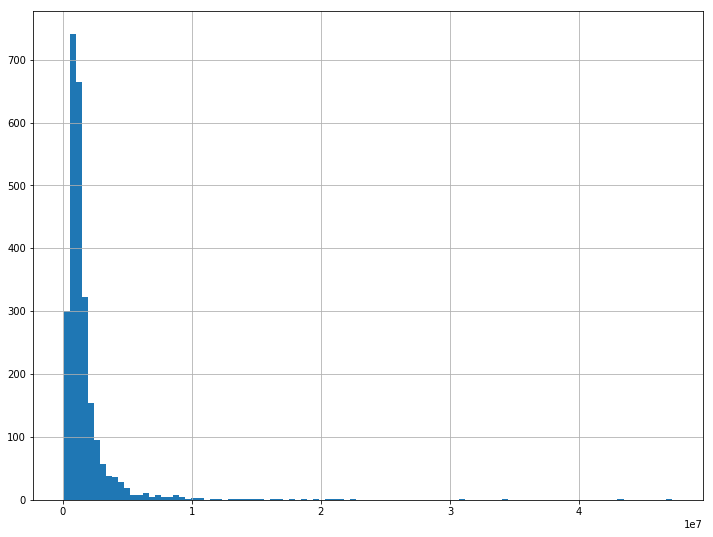

In [71]:
df_ted['views'].hist(bins=100);

In [72]:
scipy.stats.normaltest(df_ted['views'])

NormaltestResult(statistic=3634.35222369011, pvalue=0.0)

In [73]:
scipy.stats.shapiro(df_ted['views'])

(0.40940701961517334, 0.0)

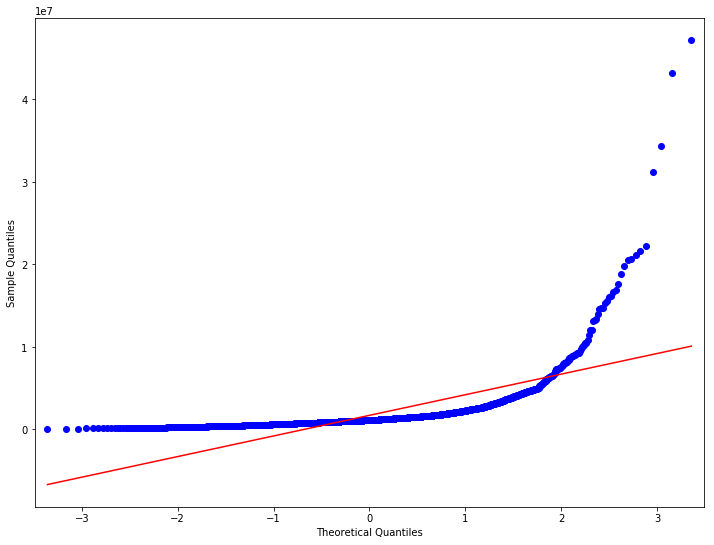

In [74]:
sm.qqplot(df_ted['views'], line='s');

In [75]:
scipy.stats.normaltest(np.log(df_ted['views']))

NormaltestResult(statistic=201.78023146791185, pvalue=1.5274938070975164e-44)

In [76]:
scipy.stats.shapiro(np.log(df_ted['views']))

(0.9729341864585876, 1.4359117312548763e-21)

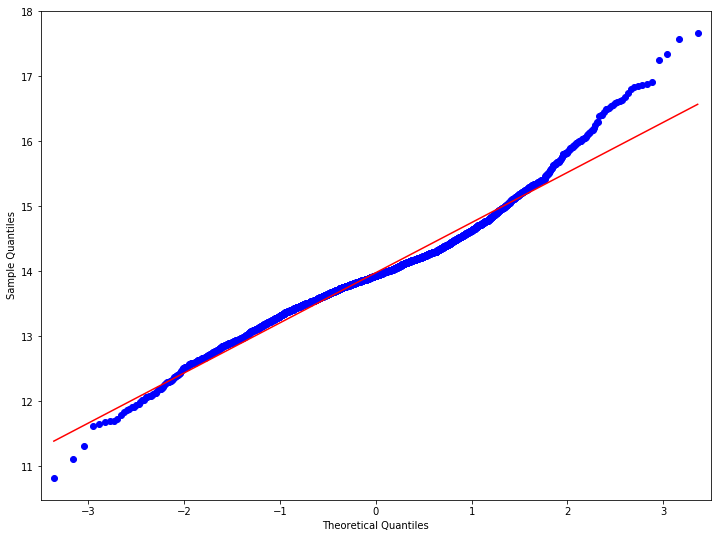

In [77]:
sm.qqplot(np.log(df_ted['views']), line='s');

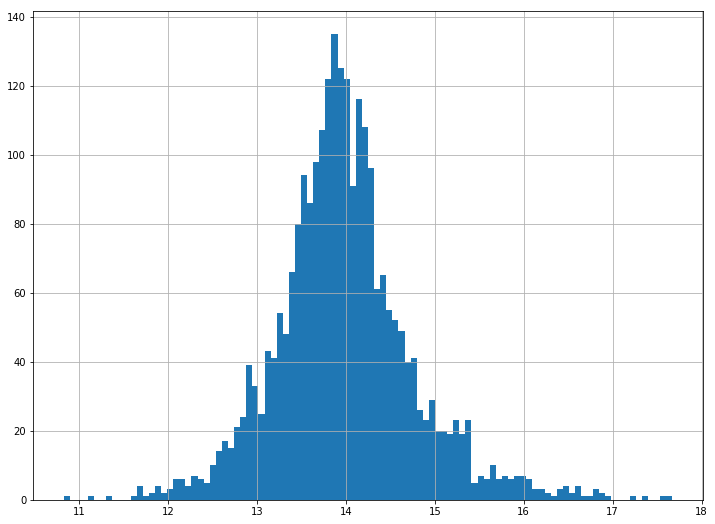

In [78]:
np.log(df_ted['views']).hist(bins=100);

In [79]:
alpha = 0.001
p = scipy.stats.shapiro(np.log(np.log(df_ted['views'])))[1]

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis can be rejected


It doesnt't looks like we get normal distibution after applying logarithm, but it looks much closer to it. So we will assume that our target variable has normal distribution.

In [80]:
df_ted.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'transcript'],
      dtype='object')

In [81]:
df_ted['target'] = np.log(df_ted['views'])

#### transcripts

In [82]:
df_ted['transcript'].nunique(), len(df_ted['transcript']), sum(df_ted['transcript'].isna())

(2464, 2550, 86)

Not every talk has transcipt and each transcript in unique.

In [83]:
df_ted['transcript'].str.len().describe()

count     2464.000000
mean     11438.002029
std       5291.533620
min         17.000000
25%       7568.000000
50%      11538.500000
75%      15113.750000
max      51355.000000
Name: transcript, dtype: float64

In [84]:
df_ted[df_ted['transcript'].str.len() < 200]['transcript'].values

array(['(Applause)(Music)(Applause)',
       "Let's just get started here.Okay, just a moment.(Whirring)All right. (Laughter) Oh, sorry.(Music) (Beatboxing)Thank you.(Applause)",
       '(Music)(Applause)(Music)(Music) (Applause)(Music) (Applause) (Applause)Herbie Hancock: Thank you. Marcus Miller. (Applause) Harvey Mason. (Applause)Thank you. Thank you very much. (Applause)',
       '(Music)(Applause)(Music)(Applause)',
       '(Music)(Applause)(Music)(Applause)(Music)(Applause)(Music)(Applause)',
       '(Mechanical noises)(Music) (Applause)', '(Music)(Applause)',
       '(Music)(Music) (Applause)(Applause)',
       '(Guitar music starts)(Music ends)(Applause)(Distorted guitar music starts)(Music ends)(Applause)(Ambient/guitar music starts)(Music ends)(Applause)',
       '(Guitar music starts)(Cheers)(Cheers)(Music ends)'], dtype=object)

Ok, looks like some transcript are from music.

### Part 3. Visual analysis of the features

In [85]:
df_ted.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'transcript', 'target'],
      dtype='object')

In [86]:
df_ted.drop('views', axis=1, inplace=True)

In [87]:
df_ted.drop('related_talks', axis=1, inplace=True)

In [88]:
df_ted.drop('comments', axis=1, inplace=True)

In [89]:
# Make separate dataframe for data preparation for plotting
df_plot = df_ted.copy()
df_plot['film_date_unix'] = df_ted['film_date'].astype(int)
df_plot['published_date_unix'] = df_ted['published_date'].astype(int)

/usr/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 2.77 s, sys: 2.55 s, total: 5.32 s
Wall time: 2.2 s


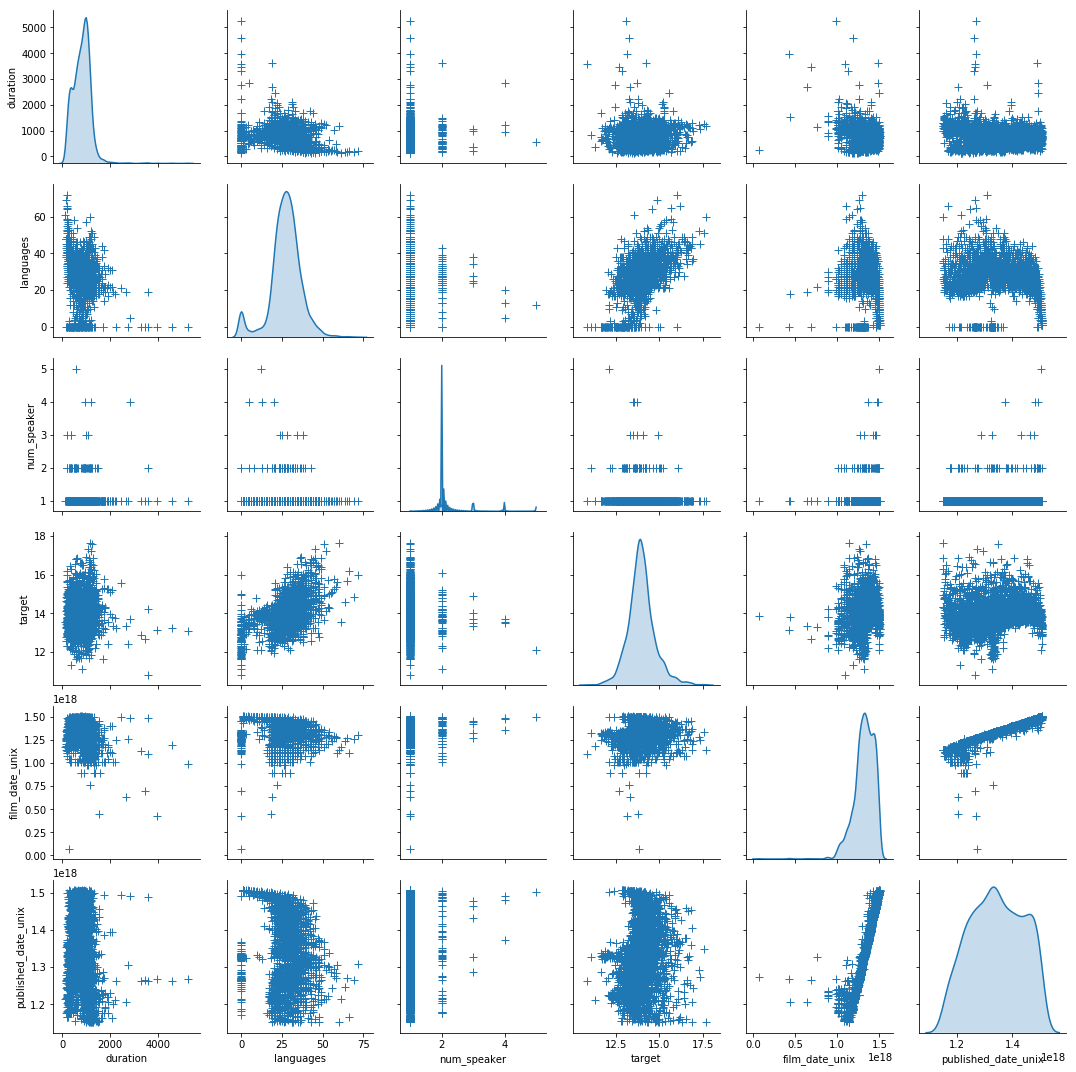

In [90]:
%%time

sns.pairplot(df_plot, diag_kind="kde", markers="+",
    plot_kws=dict(s=50, edgecolor="b", linewidth=1),
    diag_kws=dict(shade=True));

Clearly visible correlation between number of languages and views count.

In [91]:
df_ted.columns

Index(['description', 'duration', 'event', 'film_date', 'languages',
       'main_speaker', 'name', 'num_speaker', 'published_date', 'ratings',
       'speaker_occupation', 'tags', 'title', 'url', 'transcript', 'target'],
      dtype='object')

In [92]:
df_plot.corr(method='pearson')

,duration,languages,num_speaker,target,film_date_unix,published_date_unix
duration,1.000000,-0.295681,0.022257,0.012922,-0.242941,-0.166324
languages,-0.295681,1.000000,-0.063100,0.544463,-0.061957,-0.171836
num_speaker,0.022257,-0.063100,1.000000,-0.056512,0.040227,0.049240
target,0.012922,0.544463,-0.056512,1.000000,0.167044,0.144343
film_date_unix,-0.242941,-0.061957,0.040227,0.167044,1.000000,0.902565
published_date_unix,-0.166324,-0.171836,0.049240,0.144343,0.902565,1.000000


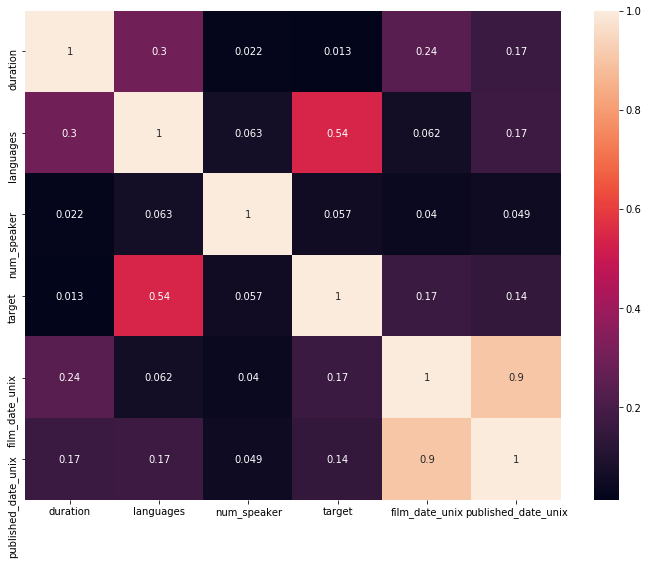

In [93]:
sns.heatmap(df_plot.corr(method='pearson').abs(), annot=True)

In [94]:
df_plot.corr(method='spearman')

,duration,languages,num_speaker,target,film_date_unix,published_date_unix
duration,1.000000,-0.325966,-0.010589,0.036616,-0.198422,-0.197449
languages,-0.325966,1.000000,-0.050928,0.497200,-0.121390,-0.149548
num_speaker,-0.010589,-0.050928,1.000000,-0.050292,0.032236,0.032061
target,0.036616,0.497200,-0.050292,1.000000,0.229521,0.208939
film_date_unix,-0.198422,-0.121390,0.032236,0.229521,1.000000,0.987641
published_date_unix,-0.197449,-0.149548,0.032061,0.208939,0.987641,1.000000


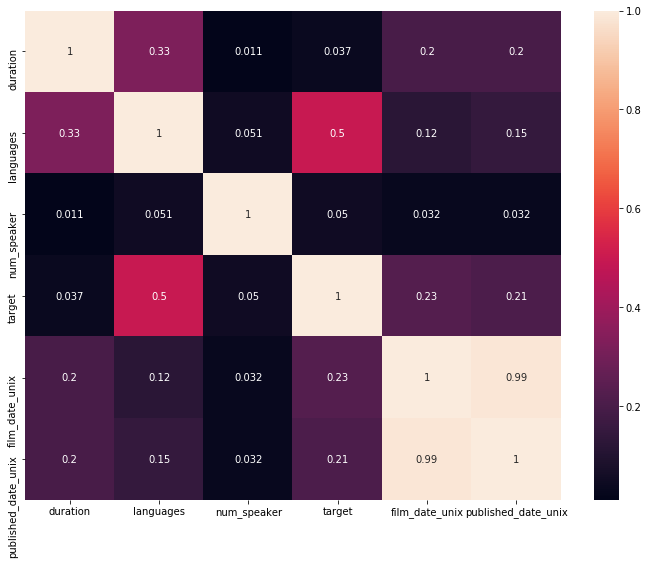

In [95]:
sns.heatmap(df_plot.corr(method='spearman').abs(), annot=True)

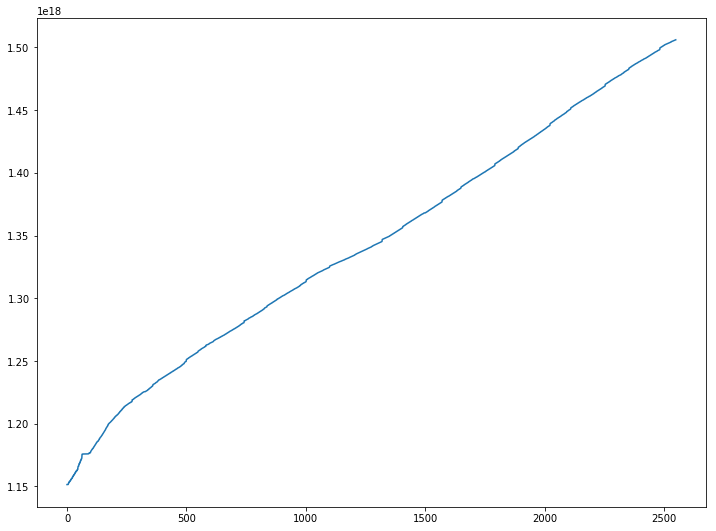

In [98]:
plt.plot(df_plot['published_date_unix'])

So, data is sorted by published_date

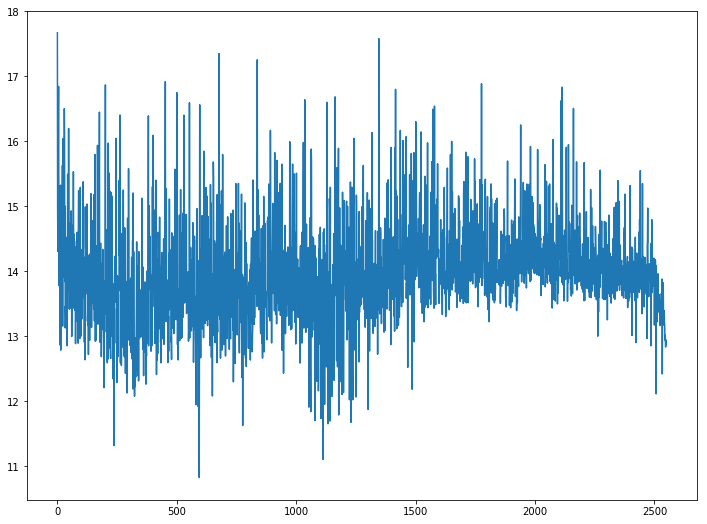

In [99]:
plt.plot(df_plot['target'])

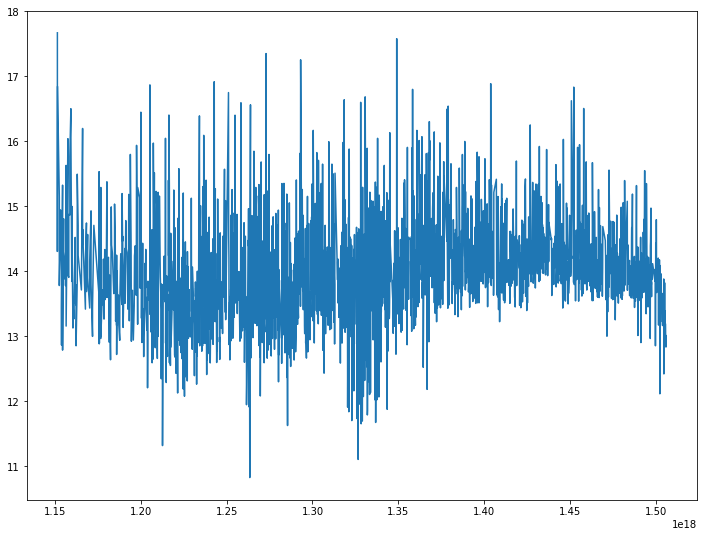

In [100]:
plt.plot(df_plot['published_date_unix'], df_plot['target'])

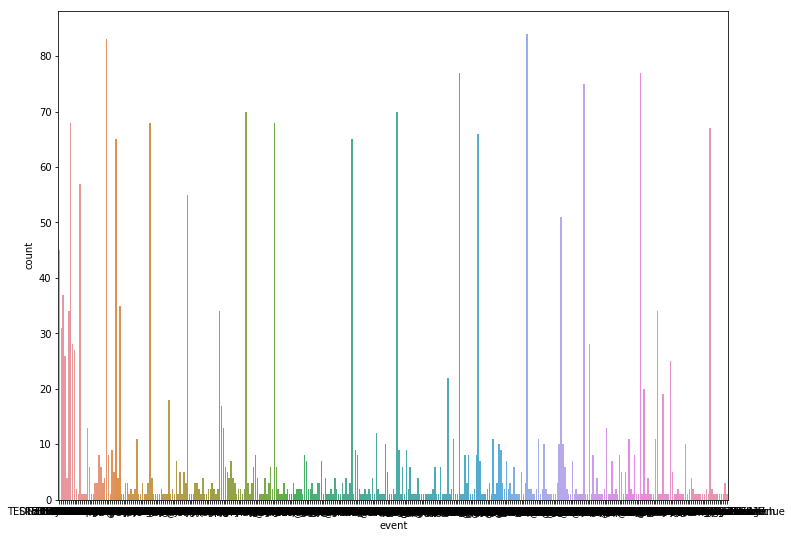

In [102]:
sns.countplot(df_ted['event']);

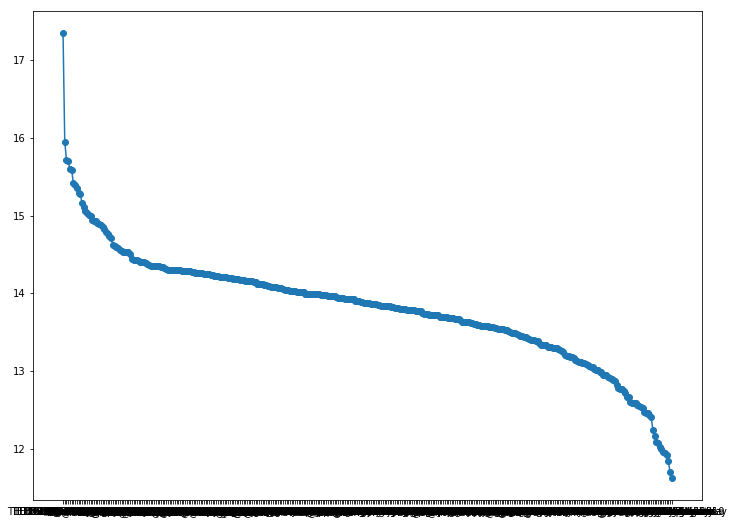

In [103]:
plt.plot(df_plot.groupby(by='event')['target'].mean().sort_values(ascending=False), 'o-');

Target mean variable looks like near normally disributed related to event name.

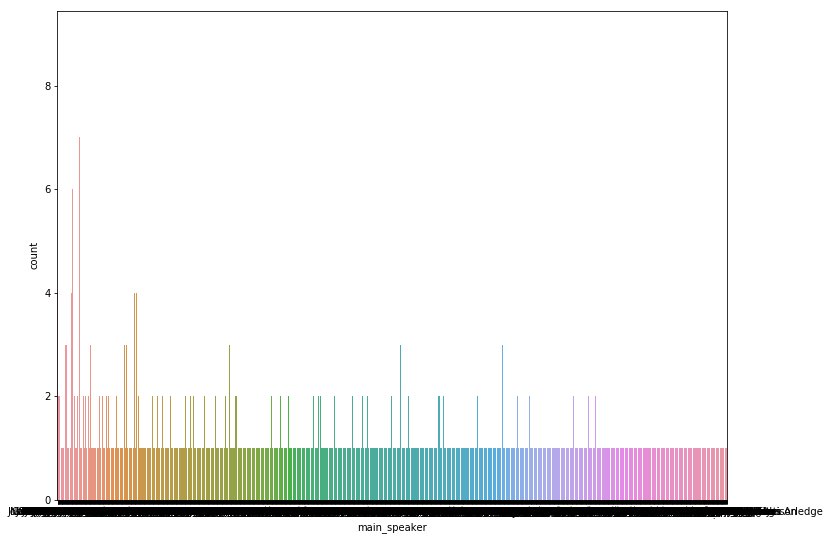

In [104]:
sns.countplot(df_ted['main_speaker']);

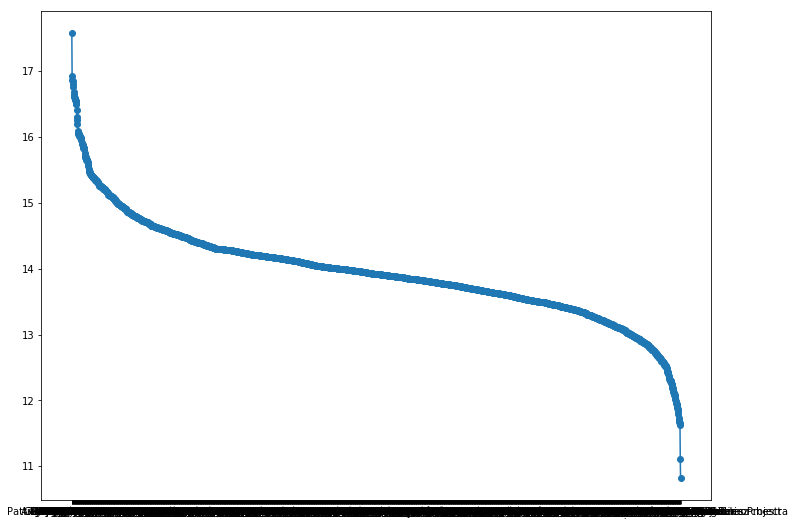

In [105]:
plt.plot(df_plot.groupby(by='main_speaker')['target'].mean().sort_values(ascending=False), 'o-');

The normality of disribution also holds for speaker name.

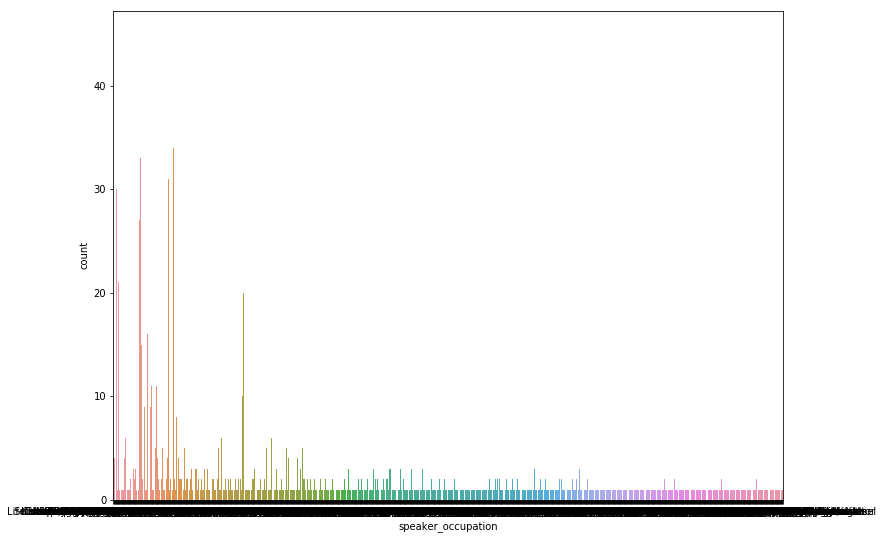

In [106]:
sns.countplot(df_ted['speaker_occupation']);

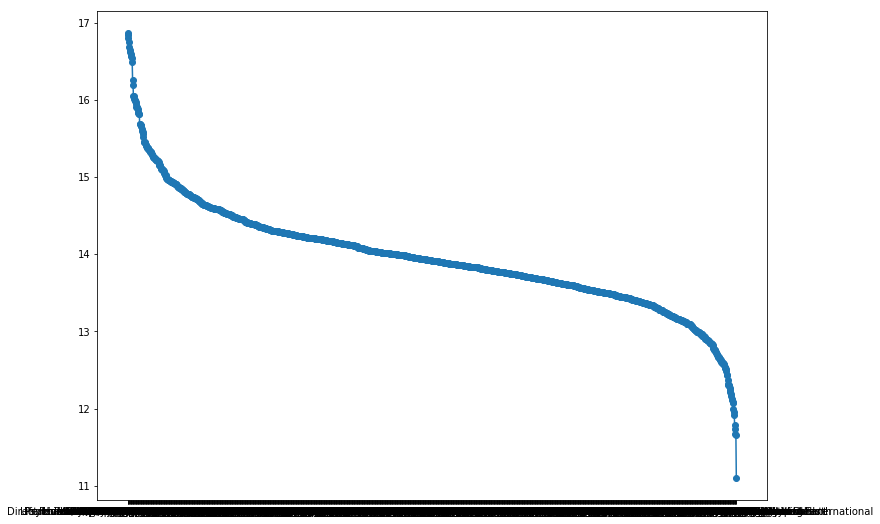

In [107]:
plt.plot(df_plot.groupby(by='speaker_occupation')['target'].mean().sort_values(ascending=False), 'o-');

speaker_occupation also looks normaly distributed.

### Part 4. Patterns, insights, pecularities of data 

From previous analysis we have following observations:
- 'view' variable is not normally distributed according to tests. For linear model it's should be more adequate to use normally distributed target variable, so we apply logarithm to it. It doesn't makes distribution normal but now it looks closer to it.
- Our new target variable highly correlated with language count. May be it's due the fact that the most popular talks are moe often translated to more languages. Because we are doing correlation analysis we cann't say it for sure without additional data. But it can be useful to omit language variable.
- Also we have strong correlation between published and film date, so we need to exclude one of them for more accurate predicictions.
- We clearly see different kind of events, so may be useful to add additional feature with event type information
- Url and name just redunant because contains information also available from other fields
- Data is sorted by published date, so we can use TimeSeriesSplit to not get catched by data leak. Also it's fine because we are interested in feature prediction so we don't need to sort data.
- We have some errors in data, when published_date is smaller than film_date, but as we are more interested in date of publication and published_date and film_date are highly correlated we will exclude film_date

### Part 5. Data preprocessing

We will do different type of preprocessing for different type of columns:
- numeric columns will be scaled using StandardScaler
- text columns will be converter to lower case and after that vectorized using TfIdfVectorizer
- categorial variables will be factorized (similar to label encoding) and then transformed using OneHotEncoder
- empty values in transcript field will be filled with 'na' string
- date will be converted to unix time and used as numeric
- tags arrays will be converted to string and used as string column

In [108]:
df_ted.columns

Index(['description', 'duration', 'event', 'film_date', 'languages',
       'main_speaker', 'name', 'num_speaker', 'published_date', 'ratings',
       'speaker_occupation', 'tags', 'title', 'url', 'transcript', 'target'],
      dtype='object')

In [226]:
# Only leave features filtred by assumptions from previous part
X = df_ted[['description', 'duration', 'event', 'languages',
       'main_speaker', 'num_speaker', 'published_date',
       'speaker_occupation', 'tags', 'title', 'transcript']].copy()
y = df_ted['target'].copy()

NUMERIC_COLUMNS = ['duration', 'languages']
DATE_COLUMNS = ['published_date']

# We will convert 'tags' column to string
TEXT_COLUMNS = ['description', 'tags', 'title', 'transcript']

CATEGORICAL_COLUMNS = ['event',
       'main_speaker', 'speaker_occupation', 'num_speaker']

# We will convert published_date back to unix time and use it like numeric column
for c in DATE_COLUMNS:
    X[c] = X[c].astype(int)

# We will use data columns simply as numeric_column, so 
NUMERIC_COLUMNS += DATE_COLUMNS

# StandardScaler will convert fields to float64 with warning, so we will do it before
for c in NUMERIC_COLUMNS:
    X[c] = X[c].astype(float)

# Convert tags to string
X['tags'] = X['tags'].apply(lambda tags: ' '.join(tags))

X['transcript'] = X['transcript'].fillna('na')

# Convert all text columns to lower case
for c in TEXT_COLUMNS:
    X[c] = X[c].str.lower()

# Factorize categorical_columns (similar to LabelEncoding)
for c in CATEGORICAL_COLUMNS:
    X[c] = X[c].factorize()[0]

In [227]:
X.head()

,description,duration,event,languages,main_speaker,num_speaker,published_date,speaker_occupation,tags,title,transcript
0,sir ken robinson makes an entertaining and pro...,1164.0,0,60.0,0,0,1.151367e+18,0,children creativity culture dance education pa...,do schools kill creativity?,good morning. how are you?(laughter)it's been ...
1,with the same humor and humanity he exuded in ...,977.0,0,43.0,1,0,1.151367e+18,1,alternative energy cars climate change culture...,averting the climate crisis,"thank you so much, chris. and it's truly a gre..."
2,new york times columnist david pogue takes aim...,1286.0,0,26.0,2,0,1.151367e+18,2,computers entertainment interface design media...,simplicity sells,"(music: ""the sound of silence,"" simon & garfun..."
3,"in an emotionally charged talk, macarthur-winn...",1116.0,0,35.0,3,0,1.151367e+18,3,macarthur grant activism business cities envir...,greening the ghetto,if you're here today — and i'm very happy that...
4,you've never seen data presented like this. wi...,1190.0,0,48.0,4,0,1.151441e+18,4,africa asia google demo economics global devel...,the best stats you've ever seen,"about 10 years ago, i took on the task to teac..."


In [228]:
preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

In [229]:
# It's crucial not sort splits, because we want to predict future (so no future data should be in train set)
# We don't need seed here because shuffle is disabled
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle=False)

In [230]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1785, 11), (765, 11), (1785,), (765,))

### Part 6.  Metric selection

For regression task there are two most popular metrics - RMSE and MAE.

$
\begin{align}
RMSE = \sqrt{\frac{1}{n}\sum_{j=1}^{n}{(\hat{y} - y_j)^2}}
\end{align}
$

$
\begin{align}
MAE = \frac{1}{n}\sum_{j=1}^{n}{\lvert\hat{y} - y_j\rvert}
\end{align}
$

RMSE put higher weight on the bigger errors in predictions.
RMSE has tendency to increase more then MAE with bigger sample size.
In our case bigger errors should not be threated in special way.
MAE is more easy to interpretate, especially as we have log transformation of initial target variable, so exp(MAE) could be viewed as multiplicator of true value of the original variable.

So we will go with MAE.


### Part 7. Feature engineering and description 

Let's try Ridge from sklearn.

In [319]:
%%time
model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)


cv = GridSearchCV(model_ridge, param_grid={}, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... , score=-0.529572765869789, total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ...................... , score=-0.4670555265153398, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] ...................... , score=-0.4514045360568452, total=   2.7s
[CV]  ................................................................
[CV] ..................... , score=-0.48895244539870886, total=   3.3s
[CV]  ................................................................
[CV] ..................... , score=-0.46075069989416256, total=   4.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.5s finished


CPU times: user 26 s, sys: 29.3 ms, total: 26 s
Wall time: 26 s


In [320]:
cv.best_score_

-0.4795471947469691

We will use it as baseline for future.

Let's construct new features:
- len of transcript (because target can depends on how much time presenter speaks)
- event type, because it's some events are clearly more popular (like TED events vs regional TEDx events)
- published_date hour, month, dayofweek

In [322]:
# Only leave features filtred by assumptions from previous part
X = df_ted[['description', 'duration', 'event', 'languages',
       'main_speaker', 'num_speaker', 'published_date',
       'speaker_occupation', 'tags', 'title', 'transcript']].copy()
y = df_ted['target'].copy()

X['transcript'] = X['transcript'].fillna('na')
X['transcript_len'] = X['transcript'].str.len()
X['event_type'] = X['event'].apply(get_event_type)
X['published_hour'] = X['published_date'].dt.hour
X['published_month'] = X['published_date'].dt.month
X['published_dayofweek'] = X['published_date'].dt.dayofweek


NUMERIC_COLUMNS = ['duration', 'languages',
                   'transcript_len'
                  ]
DATE_COLUMNS = ['published_date']

# We will convert 'tags' column to string
TEXT_COLUMNS = ['description', 'tags', 'title', 'transcript']

CATEGORICAL_COLUMNS = ['event',
       'main_speaker', 'speaker_occupation', 'num_speaker', 
                       'event_type',
                       'published_hour',
                       'published_month',
                       'published_dayofweek'
                      ]

# We will convert published_date back to unix time and use it like numeric column
for c in DATE_COLUMNS:
    X[c] = X[c].astype(int)

# We will use data columns simply as numeric_column, so 
NUMERIC_COLUMNS += DATE_COLUMNS

# Convert tags to string
X['tags'] = X['tags'].apply(lambda tags: ' '.join(tags))

# StandardScaler will convert fields to float64 with warning, so we will do it before
for c in NUMERIC_COLUMNS:
    X[c] = X[c].astype(float)

# Convert all text columns to lower case
for c in TEXT_COLUMNS:
    X[c] = X[c].str.lower()

# Factorize categorical_columns (similar to LabelEncoding)
for c in CATEGORICAL_COLUMNS:
    X[c] = X[c].factorize()[0]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle=False)

We will test new features it one by one, using ColumnTransformer propery - it will drop columns, not mentnioned in transformers list.

#### Let's try to exclude published_date

In [323]:
%%time
NUMERIC_COLUMNS = ['duration', 'languages']

CATEGORICAL_COLUMNS = ['event',
       'main_speaker', 'speaker_occupation', 'num_speaker']

preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)


cv = GridSearchCV(model_ridge, param_grid={}, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... , score=-0.5515183016074823, total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ....................... , score=-0.450775278258968, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] ...................... , score=-0.4427393393712061, total=   2.6s
[CV]  ................................................................
[CV] ...................... , score=-0.4683652757283662, total=   3.6s
[CV]  ................................................................
[CV] ...................... , score=-0.4704698330144345, total=   3.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.7s finished


CPU times: user 26.1 s, sys: 52 ms, total: 26.2 s
Wall time: 26.2 s


In [324]:
cv.best_score_

-0.4767736055960914

We have some improvement in score, let's continue.

#### transcript_len

In [325]:
%%time
NUMERIC_COLUMNS = ['duration', 'languages', 'transcript_len'
                  ]

CATEGORICAL_COLUMNS = ['event',
       'main_speaker', 'speaker_occupation', 'num_speaker']

preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)


cv = GridSearchCV(model_ridge, param_grid={}, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... , score=-0.5388501938587508, total=   1.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ..................... , score=-0.43580727618207843, total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] ..................... , score=-0.44389246819413897, total=   2.6s
[CV]  ................................................................
[CV] ..................... , score=-0.47417138790282504, total=   3.1s
[CV]  ................................................................
[CV] ...................... , score=-0.4850193724144867, total=   3.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.1s finished


CPU times: user 25.1 s, sys: 29 ms, total: 25.2 s
Wall time: 25.2 s


In [326]:
cv.best_score_

-0.475548139710456

Previous value was -0.4767736055960914, so we have some small imporvement.

#### event_type

In [340]:
%%time
NUMERIC_COLUMNS = ['duration', 'languages', 'transcript_len']

CATEGORICAL_COLUMNS = [
       'main_speaker', 'speaker_occupation', 'num_speaker', 'event_type']

preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)


cv = GridSearchCV(model_ridge, param_grid={}, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... , score=-0.5322149001704244, total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ...................... , score=-0.4690839922595546, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] ...................... , score=-0.4444954311015843, total=   2.7s
[CV]  ................................................................
[CV] ..................... , score=-0.47892641110948575, total=   3.3s
[CV]  ................................................................
[CV] ...................... , score=-0.4364469923530735, total=   4.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.5s finished


CPU times: user 26.2 s, sys: 75.3 ms, total: 26.3 s
Wall time: 26.3 s


In [341]:
cv.best_score_

-0.4722335453988245

This is our new best crossval score

#### published_hour

In [342]:
%%time
NUMERIC_COLUMNS = ['duration', 'languages', 'transcript_len'
                  ]

CATEGORICAL_COLUMNS = ['event_type',
       'main_speaker', 'speaker_occupation', 'num_speaker', 'published_hour']

preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)


cv = GridSearchCV(model_ridge, param_grid={}, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... , score=-0.5307546302183648, total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ...................... , score=-0.4823182767578877, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] ..................... , score=-0.45352675804496617, total=   2.6s
[CV]  ................................................................
[CV] ..................... , score=-0.49771810106941766, total=   3.5s
[CV]  ................................................................
[CV] ...................... , score=-0.4153635981565675, total=   3.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.3s finished


CPU times: user 25.8 s, sys: 61.1 ms, total: 25.9 s
Wall time: 25.9 s


In [343]:
cv.best_score_

-0.47593627284944073

Not improvement of the best score

#### published_month

In [344]:
%%time
NUMERIC_COLUMNS = ['duration', 'languages', 'transcript_len'
                  ]

CATEGORICAL_COLUMNS = ['event_type',
       'main_speaker', 'speaker_occupation', 'num_speaker', 'published_month']

preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)


cv = GridSearchCV(model_ridge, param_grid={}, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... , score=-0.541120473167134, total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ...................... , score=-0.4878525644474154, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] ...................... , score=-0.4491814631916443, total=   2.7s
[CV]  ................................................................
[CV] ..................... , score=-0.47936596719331287, total=   3.2s
[CV]  ................................................................
[CV] ...................... , score=-0.4436368339011812, total=   3.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.3s finished


CPU times: user 25.5 s, sys: 71.7 ms, total: 25.6 s
Wall time: 25.6 s


In [346]:
cv.best_score_

-0.48023146038013753

Not improvement of score

#### published_dayofweek

In [347]:
%%time
NUMERIC_COLUMNS = ['duration', 'languages', 'transcript_len'
                  ]

CATEGORICAL_COLUMNS = ['event_type',
       'main_speaker', 'speaker_occupation', 'num_speaker', 'published_dayofweek']

preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)


cv = GridSearchCV(model_ridge, param_grid={}, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... , score=-0.5545001113157026, total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ..................... , score=-0.46930188759870906, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] ..................... , score=-0.45479889351105673, total=   2.6s
[CV]  ................................................................
[CV] ...................... , score=-0.4804840991338316, total=   3.2s
[CV]  ................................................................
[CV] ..................... , score=-0.43782215712619676, total=   3.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.1s finished


CPU times: user 25.3 s, sys: 58.9 ms, total: 25.3 s
Wall time: 25.3 s


In [348]:
cv.best_score_

-0.4793814297370994

Not improvement of the score

#### Conclusion on feature engineering

We just found two new useful features:
- event_type instead of event
- transcript_len

Cross validation on Ridge shows score improvement with both of them.

### Part 8. Cross-validation, hyperparameter tuning

We will use features we already found and selected.

In [350]:
%%time

X = df_ted[['description', 'duration', 'event', 'languages',
       'main_speaker', 'num_speaker',
       'speaker_occupation', 'tags', 'title', 'transcript']].copy()
y = df_ted['target'].copy()

X['transcript'] = X['transcript'].fillna('na')
X['transcript_len'] = X['transcript'].str.len()
X['event_type'] = X['event'].apply(get_event_type)
X.drop('event', axis=1, inplace=True)

NUMERIC_COLUMNS = ['duration', 'languages', 'transcript_len']

CATEGORICAL_COLUMNS = ['main_speaker', 'speaker_occupation', 'num_speaker', 'event_type']


# We will convert 'tags' column to string
TEXT_COLUMNS = ['description', 'tags', 'title', 'transcript']

# Convert tags to string
X['tags'] = X['tags'].apply(lambda tags: ' '.join(tags))

# StandardScaler will convert fields to float64 with warning, so we will do it before
for c in NUMERIC_COLUMNS:
    X[c] = X[c].astype(float)

# Convert all text columns to lower case
for c in TEXT_COLUMNS:
    X[c] = X[c].str.lower()

# Factorize categorical_columns (similar to LabelEncoding)
for c in CATEGORICAL_COLUMNS:
    X[c] = X[c].factorize()[0]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle=False)

CPU times: user 163 ms, sys: 2.92 ms, total: 166 ms
Wall time: 164 ms


In [351]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1785, 11), (765, 11), (1785,), (765,))

In [395]:
preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), CATEGORICAL_COLUMNS),
    ('scaler', StandardScaler(), NUMERIC_COLUMNS),
    ('tfidf_0', TfidfVectorizer(), TEXT_COLUMNS[0]),
    ('tfidf_1', TfidfVectorizer(), TEXT_COLUMNS[1]),
    ('tfidf_2', TfidfVectorizer(), TEXT_COLUMNS[2]),
    ('tfidf_3', TfidfVectorizer(), TEXT_COLUMNS[3]),
])

Let's tune alpha (l1 regularization) for Ridge.

In [390]:
model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED))
    ]
)

params = {
    
    'ridge__alpha' : np.logspace(-2, 5, num=8)
}

cv = GridSearchCV(model_ridge, param_grid=params, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] ridge__alpha=0.01 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... ridge__alpha=0.01, score=-0.5357153659348366, total=   1.8s
[CV] ridge__alpha=0.01 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] ..... ridge__alpha=0.01, score=-0.4793202746461553, total=   2.2s
[CV] ridge__alpha=0.01 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] ...... ridge__alpha=0.01, score=-0.448421181620962, total=   3.0s
[CV] ridge__alpha=0.01 ...............................................
[CV] ..... ridge__alpha=0.01, score=-0.4906695619710239, total=   3.7s
[CV] ridge__alpha=0.01 ...............................................
[CV] .... ridge__alpha=0.01, score=-0.44097338299417826, total=   4.4s
[CV] ridge__alpha=0.1 ................................................
[CV] ...... ridge__alpha=0.1, score=-0.5353455161397344, total=   1.3s
[CV] ridge__alpha=0.1 ................................................
[CV] ...... ridge__alpha=0.1, score=-0.4780922412197138, total=   2.1s
[CV] ridge__alpha=0.1 ................................................
[CV] ...... ridge__alpha=0.1, score=-0.4477217958033026, total=   2.7s
[CV] ridge__alpha=0.1 ................................................
[CV] ...... ridge__alpha=0.1, score=-0.4893866331473308, total=   3.5s
[CV] ridge__alpha=0.1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values... fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=3)

In [391]:
cv.best_score_

-0.46442528954529266

In [392]:
cv.best_params_

{'ridge__alpha': 10.0}

In [393]:
def plot_param_tuning(params, param_name, cv, x_scale_log=False):

    plt.plot(params[param_name], cv.cv_results_['mean_train_score'], 'o-', label='train')
    plt.plot(params[param_name], cv.cv_results_['mean_test_score'], 'o-', label='test')

    plt.fill_between(params[param_name],
                     cv.cv_results_['mean_train_score'] - cv.cv_results_['std_train_score'],
                     cv.cv_results_['mean_train_score'] + cv.cv_results_['std_train_score'],
                     alpha=0.2
                    )
    plt.fill_between(params[param_name],
                     cv.cv_results_['mean_test_score'] - cv.cv_results_['std_test_score'],
                     cv.cv_results_['mean_test_score'] + cv.cv_results_['std_test_score'],
                     alpha=0.2
                    )
    if x_scale_log:
        plt.xscale('log')

    plt.legend();

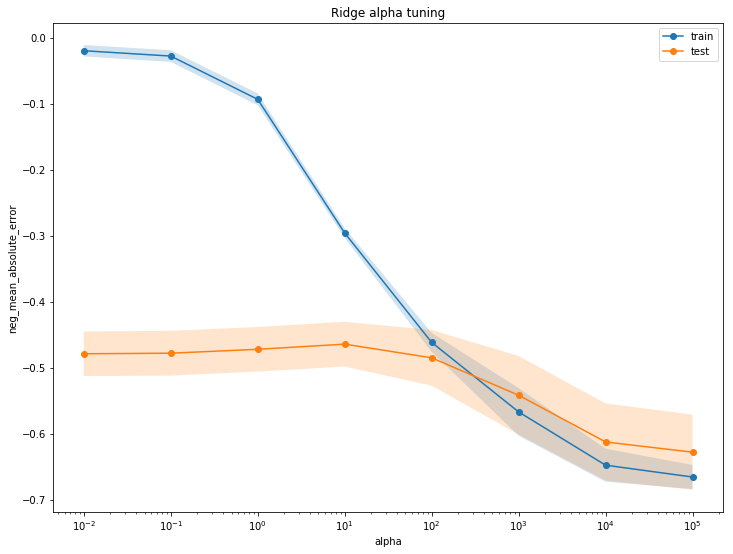

In [398]:
plot_param_tuning(params, 'ridge__alpha', cv, x_scale_log=True)
plt.xlabel('alpha')
plt.ylabel('neg_mean_absolute_error')
plt.title('Ridge alpha tuning');

It rather difficult to select good alpha value, because of wide range in standard deviation and different sample sizes due to TimeSeriesSplit. But we can consider alpha=10^2 as good guess because here is minimal difference between train and test sample.

In [399]:
model_lgb = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('lgb', LGBMRegressor(random_state=RANDOM_SEED))
    ]
)

params = {
}

cv = GridSearchCV(model_lgb, param_grid=params, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... , score=-0.5377324746200957, total=   3.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ...................... , score=-0.4423628653660104, total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV] ...................... , score=-0.5044568359615489, total=   9.2s
[CV]  ................................................................
[CV] ..................... , score=-0.48230697124313326, total=   9.8s
[CV]  ................................................................
[CV] ...................... , score=-0.5002212593493808, total=  12.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values....0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=3)

In [401]:
cv.best_score_

-0.4934160813080337

In [402]:
%%time

model_lgb = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('lgb', LGBMRegressor(random_state=RANDOM_SEED))
    ]
)

params = {
    'lgb__max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
}

cv = GridSearchCV(model_lgb, param_grid=params, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] lgb__max_depth=2 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... lgb__max_depth=2, score=-0.5363547363643915, total=   2.6s
[CV] lgb__max_depth=2 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ...... lgb__max_depth=2, score=-0.4337780170809148, total=   2.5s
[CV] lgb__max_depth=2 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] ..... lgb__max_depth=2, score=-0.48950605455392715, total=   3.1s
[CV] lgb__max_depth=2 ................................................
[CV] ...... lgb__max_depth=2, score=-0.4718975528129215, total=   3.9s
[CV] lgb__max_depth=2 ................................................
[CV] ..... lgb__max_depth=2, score=-0.48978397338973145, total=   4.6s
[CV] lgb__max_depth=3 ................................................
[CV] ...... lgb__max_depth=3, score=-0.5400955390757082, total=   1.6s
[CV] lgb__max_depth=3 ................................................
[CV] ...... lgb__max_depth=3, score=-0.4372414722430798, total=   2.6s
[CV] lgb__max_depth=3 ................................................
[CV] ...... lgb__max_depth=3, score=-0.5000008257113193, total=   3.5s
[CV] lgb__max_depth=3 ................................................
[CV] ...... lgb__max_depth=3, score=-0.4746778905394939, total=   4.9s
[CV] lgb__max_depth=3 ................................................
[CV] .

[CV] ..... lgb__max_depth=14, score=-0.5377324746200957, total=   2.6s
[CV] lgb__max_depth=14 ...............................................
[CV] ..... lgb__max_depth=14, score=-0.4372661787934551, total=   6.8s
[CV] lgb__max_depth=14 ...............................................
[CV] ...... lgb__max_depth=14, score=-0.506699137329816, total=   7.4s
[CV] lgb__max_depth=14 ...............................................
[CV] ..... lgb__max_depth=14, score=-0.4793763908093043, total=   9.8s
[CV] lgb__max_depth=14 ...............................................
[CV] .... lgb__max_depth=14, score=-0.49677176330703043, total=  11.4s
[CV] lgb__max_depth=15 ...............................................
[CV] ..... lgb__max_depth=15, score=-0.5377324746200957, total=   2.0s
[CV] lgb__max_depth=15 ...............................................
[CV] ...... lgb__max_depth=15, score=-0.434209459061889, total=   4.6s
[CV] lgb__max_depth=15 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 10.1min finished


CPU times: user 23min 5s, sys: 2.28 s, total: 23min 7s
Wall time: 10min 10s


In [403]:
cv.best_score_

-0.48426406684037726

In [405]:
cv.best_params_

{'lgb__max_depth': 2}

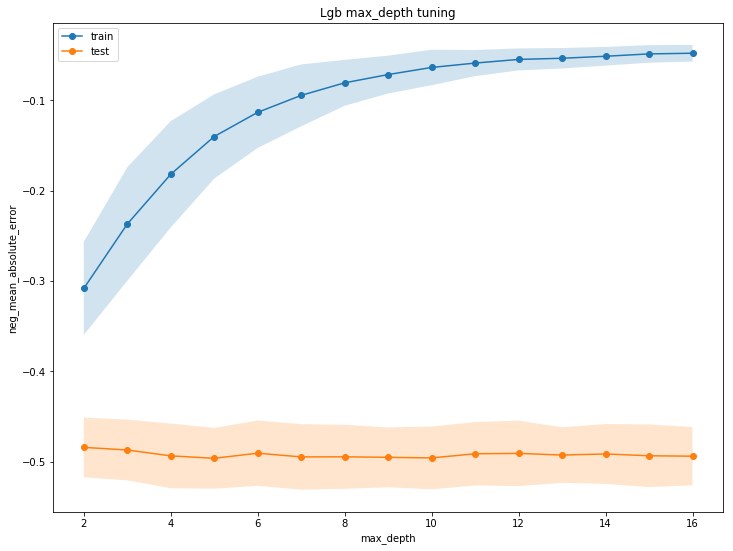

In [404]:
plot_param_tuning(params, 'lgb__max_depth', cv)
plt.xlabel('max_depth')
plt.ylabel('neg_mean_absolute_error')
plt.title('Lgb max_depth tuning');

Definitely we can't say something about the best max_depth for lgbm regression. We will tune n_estimators.

In [408]:
model_lgb = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('lgb', LGBMRegressor(random_state=RANDOM_SEED))
    ]
)

params = {
    'lgb__n_estimators': [10,20,30,40,50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500, 600, 700]
}

cv = GridSearchCV(model_lgb, param_grid=params, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
[CV] lgb__n_estimators=10 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. lgb__n_estimators=10, score=-0.5704075630162672, total=   1.5s
[CV] lgb__n_estimators=10 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .. lgb__n_estimators=10, score=-0.4602881734388482, total=   2.3s
[CV] lgb__n_estimators=10 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] .. lgb__n_estimators=10, score=-0.5393222999788543, total=   2.9s
[CV] lgb__n_estimators=10 ............................................
[CV] . lgb__n_estimators=10, score=-0.48327335297581514, total=   3.9s
[CV] lgb__n_estimators=10 ............................................
[CV] .. lgb__n_estimators=10, score=-0.5078109223272281, total=   4.3s
[CV] lgb__n_estimators=20 ............................................
[CV] .. lgb__n_estimators=20, score=-0.5362452566257339, total=   1.5s
[CV] lgb__n_estimators=20 ............................................
[CV] .. lgb__n_estimators=20, score=-0.4453640881911521, total=   2.4s
[CV] lgb__n_estimators=20 ............................................
[CV] .. lgb__n_estimators=20, score=-0.5201864928943168, total=   3.4s
[CV] lgb__n_estimators=20 ............................................
[CV] ... lgb__n_estimators=20, score=-0.466466612244034, total=   4.3s
[CV] lgb__n_estimators=20 ............................................
[CV] .

[CV] . lgb__n_estimators=300, score=-0.5491311151121193, total=   3.5s
[CV] lgb__n_estimators=300 ...........................................
[CV]  lgb__n_estimators=300, score=-0.45022361853202403, total=  11.2s
[CV] lgb__n_estimators=300 ...........................................
[CV] . lgb__n_estimators=300, score=-0.5060223575705517, total=  23.0s
[CV] lgb__n_estimators=300 ...........................................
[CV] . lgb__n_estimators=300, score=-0.4857309457425839, total=  28.5s
[CV] lgb__n_estimators=300 ...........................................
[CV] . lgb__n_estimators=300, score=-0.5013471854652972, total=  40.7s
[CV] lgb__n_estimators=400 ...........................................
[CV] . lgb__n_estimators=400, score=-0.5501760049623023, total=   4.8s
[CV] lgb__n_estimators=400 ...........................................
[CV] . lgb__n_estimators=400, score=-0.4522311543246044, total=  14.5s
[CV] lgb__n_estimators=400 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed: 23.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values....0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lgb__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500, 600, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=3)

In [409]:
cv.best_score_, cv.best_params_

(-0.4895422360731271, {'lgb__n_estimators': 30})

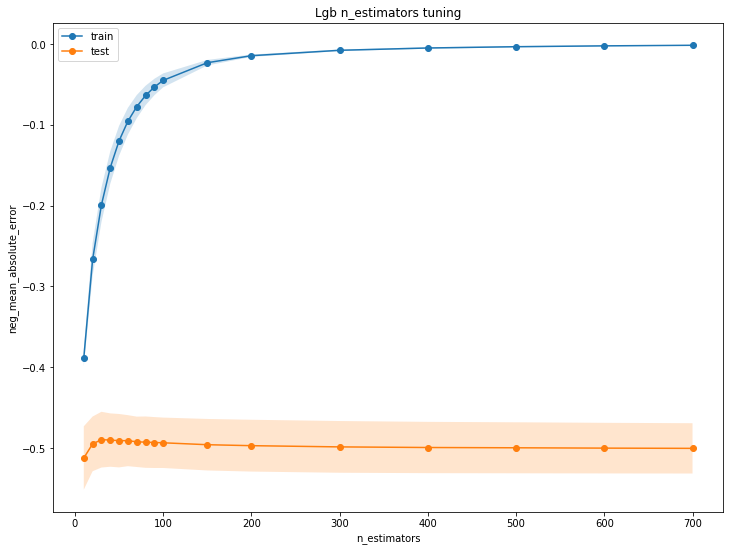

In [410]:
plot_param_tuning(params, 'lgb__n_estimators', cv)
plt.xlabel('n_estimators')
plt.ylabel('neg_mean_absolute_error')
plt.title('Lgb n_estimators tuning');

In [413]:
model_lgb = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('lgb', LGBMRegressor(random_state=RANDOM_SEED))
    ]
)

params = {
    'lgb__n_estimators': [30],
    'lgb__num_leaves':np.linspace(10,51, num=10, dtype=int)
}

cv = GridSearchCV(model_lgb, param_grid=params, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5),
                 return_train_score=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] lgb__n_estimators=30, lgb__num_leaves=10 ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lgb__n_estimators=30, lgb__num_leaves=10, score=-0.5419863563211116, total=   1.5s
[CV] lgb__n_estimators=30, lgb__num_leaves=10 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  lgb__n_estimators=30, lgb__num_leaves=10, score=-0.43525990317293006, total=   2.5s
[CV] lgb__n_estimators=30, lgb__num_leaves=10 ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV]  lgb__n_estimators=30, lgb__num_leaves=10, score=-0.5113562183459704, total=   3.7s
[CV] lgb__n_estimators=30, lgb__num_leaves=10 ........................
[CV]  lgb__n_estimators=30, lgb__num_leaves=10, score=-0.4777361907214238, total=   3.8s
[CV] lgb__n_estimators=30, lgb__num_leaves=10 ........................
[CV]  lgb__n_estimators=30, lgb__num_leaves=10, score=-0.5091289919219117, total=   4.6s
[CV] lgb__n_estimators=30, lgb__num_leaves=14 ........................
[CV]  lgb__n_estimators=30, lgb__num_leaves=14, score=-0.5345064737463184, total=   1.5s
[CV] lgb__n_estimators=30, lgb__num_leaves=14 ........................
[CV]  lgb__n_estimators=30, lgb__num_leaves=14, score=-0.4325719286661236, total=   2.4s
[CV] lgb__n_estimators=30, lgb__num_leaves=14 ........................
[CV]  lgb__n_estimators=30, lgb__num_leaves=14, score=-0.5257098737091774, total=   3.2s
[CV] lgb__n_estimators=30, lgb__num_leaves=14 ........................
[CV]  lgb__n_estimators=30, lgb__num_lea

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values....0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lgb__n_estimators': [30], 'lgb__num_leaves': array([10, 14, 19, 23, 28, 32, 37, 41, 46, 51])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=3)

In [414]:
cv.best_score_, cv.best_params_

(-0.48983060166243253, {'lgb__n_estimators': 30, 'lgb__num_leaves': 28})

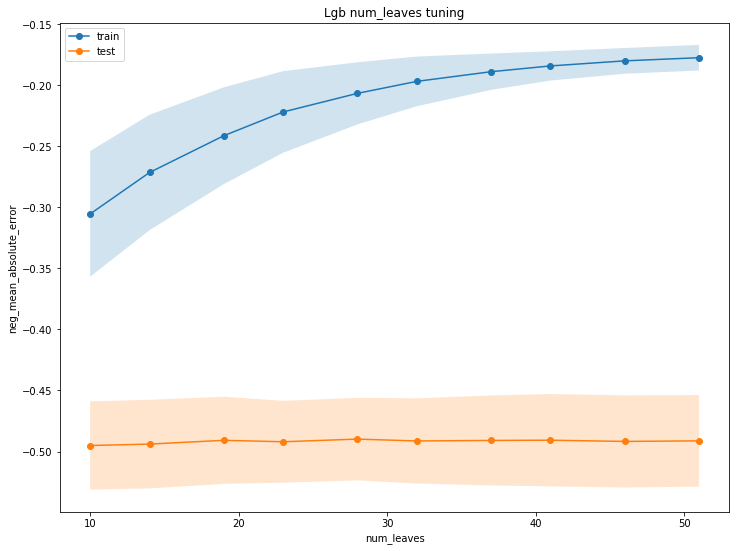

In [415]:
plot_param_tuning(params, 'lgb__num_leaves', cv)
plt.xlabel('num_leaves')
plt.ylabel('neg_mean_absolute_error')
plt.title('Lgb num_leaves tuning');

Looks like we haven't any visible success in lgbm tuning so we can use only 'lgb__n_estimators': 30 as parameter.

#### Conclusion

Our params as result of hyperparameter tuning:
- Ridge - alpha: 10 (but 100 looks better because of smaller distance between train and test)
- Lgbm regression - n_estimators: 30

### Part 9. Validation and learning curves

#### Ridge

In [422]:
X_train.shape, y_train.shape

((1785, 11), (1785,))

In [427]:
%%time

model_ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('ridge', Ridge(random_state=RANDOM_SEED, alpha=100))
    ]
)


train_sizes, train_scores, test_scores = \
    learning_curve(model_ridge, X_train, y_train, 
                   cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error', random_state=RANDOM_SEED)

CPU times: user 33.8 s, sys: 12.2 ms, total: 33.8 s
Wall time: 33.8 s


In [428]:
def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

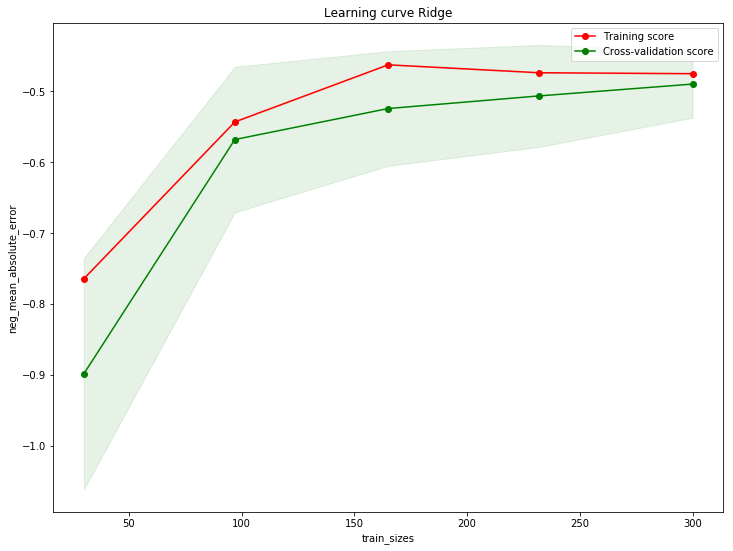

In [429]:
plot_learning_curve(train_sizes, train_scores, test_scores)
plt.xlabel('train_sizes')
plt.ylabel('neg_mean_absolute_error')
plt.title('Learning curve Ridge');

#### Lgbm regressor

In [430]:
%%time

model_lgb = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('lgb', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=30))
    ]
)

train_sizes, train_scores, test_scores = \
    learning_curve(model_lgb, X_train, y_train, 
                   cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error', random_state=RANDOM_SEED)

CPU times: user 52.8 s, sys: 48.7 ms, total: 52.8 s
Wall time: 38.7 s


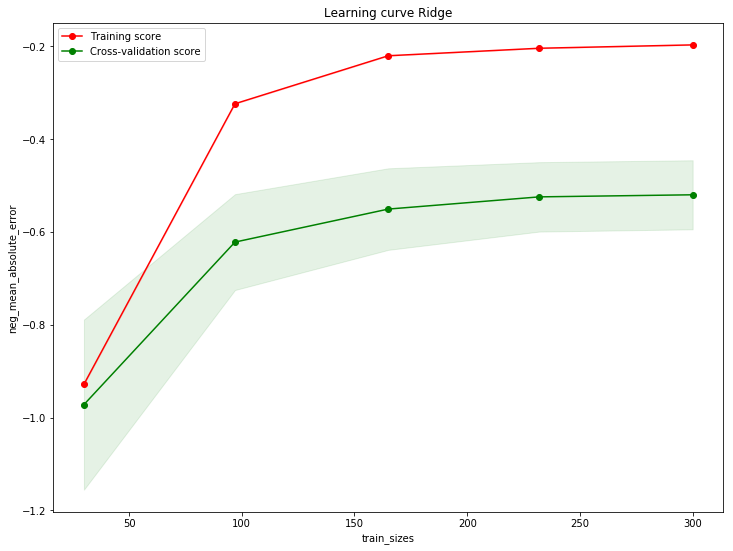

In [431]:
plot_learning_curve(train_sizes, train_scores, test_scores)
plt.xlabel('train_sizes')
plt.ylabel('neg_mean_absolute_error')
plt.title('Learning curve Ridge');

LGBRegressor tends towards overfitting, while for Ridge train and validation scores tends to look closer to each other.

### Part 10. Prediction for hold-out set

Let's check our models on hold-out set. Hold-out set was produced from all data and consist of last 30% data sorted by time.

#### Ridge

In [443]:
model_ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values... fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))])

In [444]:
ridge_mae_valid = mean_absolute_error(y_valid, model_ridge.predict(X_valid))
ridge_mae_valid

0.504339353779368

#### Lgbm regressor

In [445]:
model_lgb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values....0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [446]:
lgb_mae_valid = mean_absolute_error(y_valid, model_lgb.predict(X_valid))
lgb_mae_valid

0.46385953858023676

### Part 11. Model selection

Let's recheck cross_val_score for models.

In [447]:
%%time

ridge_cv_score = cross_val_score(model_ridge, X_train, y_train, scoring='neg_mean_absolute_error',
                                 cv=TimeSeriesSplit(n_splits=5))
lgb_cv_score = cross_val_score(model_lgb, X_train, y_train, scoring='neg_mean_absolute_error',
                                 cv=TimeSeriesSplit(n_splits=5))

CPU times: user 52.9 s, sys: 71.7 ms, total: 53 s
Wall time: 31.5 s


In [448]:
ridge_cv_score.mean(), lgb_cv_score.mean()

(-0.4851318088828598, -0.4895422360731271)

In [458]:
pd.DataFrame(index=['Ridge', 'LGBRegressor'], data = [
    [ridge_mae_valid, -ridge_cv_score.mean()],
    [lgb_mae_valid, -lgb_cv_score.mean()],
    ], columns = ['valid', 'cv_score'])

,valid,cv_score
Ridge,0.504339,0.485132
LGBRegressor,0.463860,0.489542


We've got some mess with result. No model looks like the clean winner. But on the learning plots Ridge looks more sustainable. So probably we should choose Ridge as basic model for futher research.

### Part 12. Conclusions

We've made some initial research on TED Talks dataset. 'Views' variable wasn't normally distributed so we used logarithm of it.

After parameter tuning and model selection both Ridge and LGBM regressor was able to get about 0.48 MAE on cross-validation. Despite of fact that on hold=out set LGBM outperforms Ridge, Ridge looks better on cross-validation.

The model can be useful for research on predicting TED talk popularity measured in views.

Ways to impove and futher develope the model:
- Normalization of text
- Turning Tf-IDF ngramm_range for text fields
- Usage of PCA before LGBM
- Try to get more data (more new data should be available)
- More precisely model tuning
- Research on how model will perform without 'language' variable